In [1]:
import os

# Folder path
folder_path = '/kaggle/input/cse-475/train'

# supported image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

# total image count
image_files = [f for f in os.listdir(folder_path) if os.path.splitext(f)[1].lower() in image_extensions]
print(f"Total images found: {len(image_files)}")


Total images found: 5176


In [2]:
import tensorflow as tf

# Check available devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2025-08-21 11:41:26.066703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755776486.272208      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755776486.330573      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  2


In [3]:
import os
import shutil
import pandas as pd

# Configuration
base_path = "/kaggle/input/cse-475"
csv_file = "/kaggle/input/cse-475/train/_classes.csv"  # Corrected path to the CSV file
source_folder = os.path.join(base_path, "train")      # Folder where original images are
destination_folder = "/kaggle/working1/sorted_train"  # Writable folder in Kaggle's /kaggle/working directory

# Loading the CSV file
df = pd.read_csv(csv_file)

# Creating the output folder in the writable directory
os.makedirs(destination_folder, exist_ok=True)

# Looping through each image and copying it to the proper class folder
# Assuming the label columns are 'Water Lettuce' and 'water_hyacinth' based on the DataFrame structure
label_columns = ['Water Lettuce', 'water_hyacinth']

for idx, row in df.iterrows():
    filename = row["filename"]
    
    # Finding the column with value 1 to determine the label
    label = None
    for col in label_columns:
        if row[col] == 1:
            label = col
            break

    if label is None:
        print(f"[WARNING] No label found for image: {filename}")
        continue

    # Define the path for the class folder
    class_folder = os.path.join(destination_folder, label)
    src_path = os.path.join(source_folder, filename)
    dst_path = os.path.join(class_folder, filename)

    # Creating the class folder if it doesn't exist
    os.makedirs(class_folder, exist_ok=True)

    # Copying the image if the source exists
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        print(f"[WARNING] Image not found: {src_path}")


            Class  Number of Images
0  water_hyacinth              1272
1   Water Lettuce              3904


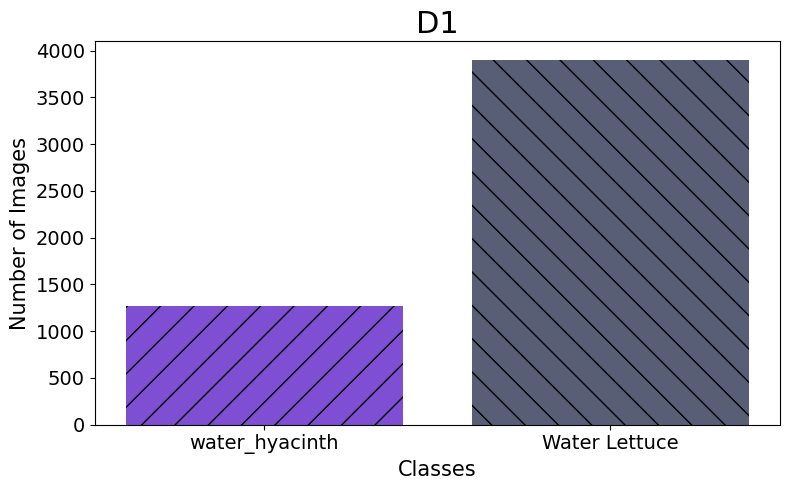

In [4]:
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import itertools
import random
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Define the path to your dataset directory
dataset_path = "/kaggle/working1/sorted_train"

plt.style.use('default')

# Get the list of categories (subfolder names)
categories = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Count the number of images in each category
image_counts = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]
    image_counts.append(len(image_files))

# Create a dataframe to show the number of images per class
data = pd.DataFrame({"Class": categories, "Number of Images": image_counts})
print(data)


# Create a bar chart to visualize the number of images in each category
plt.figure(figsize=(8, 5))
patterns = ["/", "\\", "|", "-", "+", "x", "o", "*"]  # Define patterns for bars
colors = ["#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in categories]  # Generate unique colors
bars = plt.bar(categories, image_counts, color=colors)
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.title("D1", fontsize=22)
plt.xlabel("Classes", fontsize=15)
plt.ylabel("Number of Images", fontsize=15)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('after_augmentation.png', format='png', dpi=600)
plt.show()


In [5]:
!pip install -q albumentations

# Importing Libraries
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import albumentations as A

# Defining Dataset Path and Target Count
target_count = 3500  # Target count for all classes
valid_ext = ('.jpg', '.jpeg', '.png')

# Defining Augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomCrop(height=224, width=224, p=0.3),
    A.Blur(p=0.2),
    A.GaussNoise(p=0.2),
    A.ColorJitter(p=0.3),
])

# Augmentation Process
for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    # Filtering valid images
    images = [f for f in os.listdir(class_path) if f.lower().endswith(valid_ext)]
    current_count = len(images)

    print(f"Class '{cls}' has {current_count} images.")

    if current_count < target_count:
        # Generate augmented images for underrepresented classes
        to_generate = target_count - current_count
        print(f"Generating {to_generate} augmented images for class '{cls}'...")

        for i in tqdm(range(to_generate)):
            img_name = random.choice(images)
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # If too small for cropping, we resize
            if img.shape[0] < 224 or img.shape[1] < 224:
                img = cv2.resize(img, (256, 256))
            
            # Applying augmentation
            augmented = augmentations(image=img)['image']
            
            # Saving new image with a unique name
            new_img_name = f"aug_{i}_{img_name}"
            save_path = os.path.join(class_path, new_img_name)
            cv2.imwrite(save_path, augmented)
        
    elif current_count > target_count:
        # Randomly select 3500 images for overrepresented classes
        print(f"Class '{cls}' has more than {target_count} images. Selecting 3500 images randomly...")
        
        random_images = random.sample(images, target_count)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            if img_name not in random_images:
                os.remove(img_path)  # Removing the image if it is not part of the selected 3500
        
    else:
        print(f"Class '{cls}' already has {target_count} images. No action needed.")

print("Augmentation and pruning complete. All classes now have 3500 images.")


Class 'water_hyacinth' has 1272 images.
Generating 2228 augmented images for class 'water_hyacinth'...


100%|██████████| 2228/2228 [00:27<00:00, 82.46it/s] 


Class 'Water Lettuce' has 3904 images.
Class 'Water Lettuce' has more than 3500 images. Selecting 3500 images randomly...
Augmentation and pruning complete. All classes now have 3500 images.


            Class  Number of Images
0  water_hyacinth              3500
1   Water Lettuce              3500


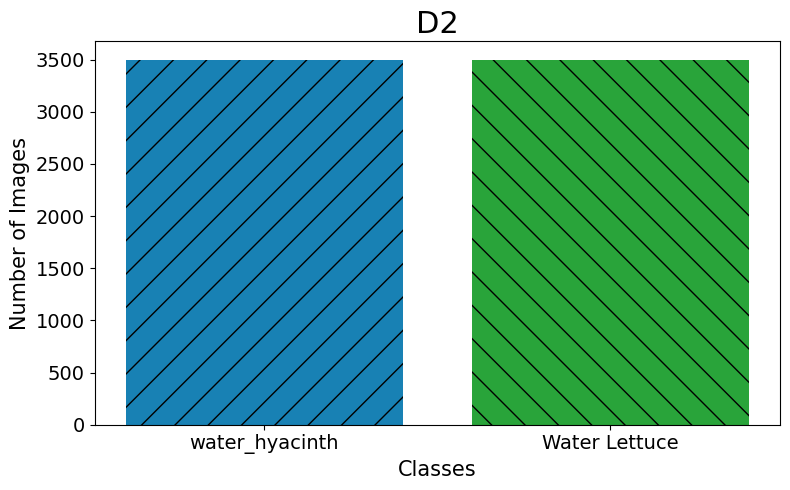

In [6]:
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import itertools
import random
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Define the path to your dataset directory
dataset_path = "/kaggle/working1/sorted_train"

plt.style.use('default')

# Get the list of categories (subfolder names)
categories = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Count the number of images in each category
image_counts = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]
    image_counts.append(len(image_files))

# Create a dataframe to show the number of images per class
data = pd.DataFrame({"Class": categories, "Number of Images": image_counts})
print(data)


# Create a bar chart to visualize the number of images in each category
plt.figure(figsize=(8, 5))
patterns = ["/", "\\", "|", "-", "+", "x", "o", "*"]  # Define patterns for bars
colors = ["#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in categories]  # Generate unique colors
bars = plt.bar(categories, image_counts, color=colors)
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.title("D2", fontsize=22)
plt.xlabel("Classes", fontsize=15)
plt.ylabel("Number of Images", fontsize=15)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('after_augmentation.png', format='png', dpi=600)
plt.show()

In [7]:
import os
import shutil
import pandas as pd

# Configuration
base_path = "/kaggle/input/cse-475"
csv_file = "/kaggle/input/cse-475/test/_classes.csv"  # Corrected path to the CSV file
source_folder = os.path.join(base_path, "test")      # Folder where original images are
destination_folder = "/kaggle/working1/sorted_test"  # Writable folder in Kaggle's /kaggle/working directory

# Loading the CSV file
df = pd.read_csv(csv_file)

# Creating the output folder in the writable directory
os.makedirs(destination_folder, exist_ok=True)

# Looping through each image and copying it to the proper class folder
# Assuming the label columns are 'Water Lettuce' and 'water_hyacinth' based on the DataFrame structure
label_columns = ['Water Lettuce', 'water_hyacinth']

for idx, row in df.iterrows():
    filename = row["filename"]
    
    # Finding the column with value 1 to determine the label
    label = None
    for col in label_columns:
        if row[col] == 1:
            label = col
            break

    if label is None:
        print(f"[WARNING] No label found for image: {filename}")
        continue

    # Define the path for the class folder
    class_folder = os.path.join(destination_folder, label)
    src_path = os.path.join(source_folder, filename)
    dst_path = os.path.join(class_folder, filename)

    # Creating the class folder if it doesn't exist
    os.makedirs(class_folder, exist_ok=True)

    # Copying the image if the source exists
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        print(f"[WARNING] Image not found: {src_path}")


            Class  Number of Images
0  water_hyacinth                56
1   Water Lettuce               225


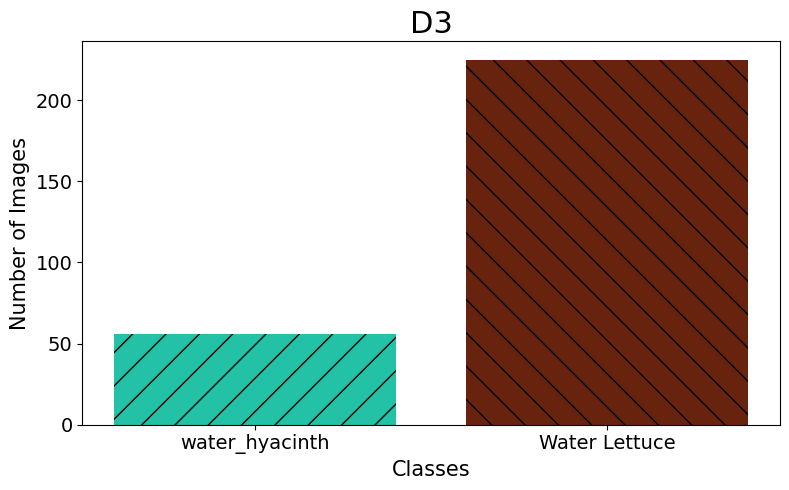

In [8]:


# Define the path to your dataset directory
dataset_path = "/kaggle/working1/sorted_test"

plt.style.use('default')

# Get the list of categories (subfolder names)
categories = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Count the number of images in each category
image_counts = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]
    image_counts.append(len(image_files))

# Create a dataframe to show the number of images per class
data = pd.DataFrame({"Class": categories, "Number of Images": image_counts})
print(data)


# Create a bar chart to visualize the number of images in each category
plt.figure(figsize=(8, 5))
patterns = ["/", "\\", "|", "-", "+", "x", "o", "*"]  # Define patterns for bars
colors = ["#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in categories]  # Generate unique colors
bars = plt.bar(categories, image_counts, color=colors)
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.title("D3", fontsize=22)
plt.xlabel("Classes", fontsize=15)
plt.ylabel("Number of Images", fontsize=15)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('after_augmentation.png', format='png', dpi=600)
plt.show()


In [9]:
!pip install -q albumentations

# Importing Libraries
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import albumentations as A

# Manually setting the dataset path (you can modify this path as needed)
dataset_path = "/kaggle/working1/sorted_test"  # Change this to your dataset path

# Defining Dataset Path and Target Count
target_count = 200  # Target count for all classes
valid_ext = ('.jpg', '.jpeg', '.png')

# Defining Augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomCrop(height=224, width=224, p=0.3),
    A.Blur(p=0.2),
    A.GaussNoise(p=0.2),
    A.ColorJitter(p=0.3),
])

# Augmentation Process
for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    # Filtering valid images
    images = [f for f in os.listdir(class_path) if f.lower().endswith(valid_ext)]
    current_count = len(images)

    print(f"Class '{cls}' has {current_count} images.")

    if current_count < target_count:
        # Generate augmented images for underrepresented classes
        to_generate = target_count - current_count
        print(f"Generating {to_generate} augmented images for class '{cls}'...")

        for i in tqdm(range(to_generate)):
            img_name = random.choice(images)
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # If too small for cropping, we resize
            if img.shape[0] < 224 or img.shape[1] < 224:
                img = cv2.resize(img, (256, 256))
            
            # Applying augmentation
            augmented = augmentations(image=img)['image']
            
            # Saving new image with a unique name
            new_img_name = f"aug_{i}_{img_name}"
            save_path = os.path.join(class_path, new_img_name)
            cv2.imwrite(save_path, augmented)
        
    elif current_count > target_count:
        # Randomly select 3500 images for overrepresented classes
        print(f"Class '{cls}' has more than {target_count} images. Selecting 200 images randomly...")
        
        random_images = random.sample(images, target_count)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            if img_name not in random_images:
                os.remove(img_path)  # Removing the image if it is not part of the selected 3500
        
    else:
        print(f"Class '{cls}' already has {target_count} images. No action needed.")

print("Augmentation and pruning complete. All classes now have 200 images.")


Class 'water_hyacinth' has 56 images.
Generating 144 augmented images for class 'water_hyacinth'...


100%|██████████| 144/144 [00:01<00:00, 94.53it/s] 

Class 'Water Lettuce' has 225 images.
Class 'Water Lettuce' has more than 200 images. Selecting 200 images randomly...
Augmentation and pruning complete. All classes now have 200 images.


            Class  Number of Images
0  water_hyacinth               200
1   Water Lettuce               200


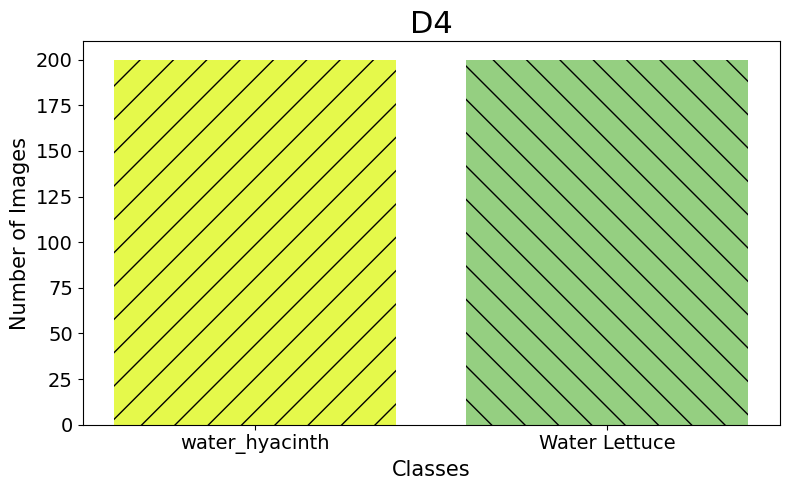

In [10]:


# Define the path to your dataset directory
dataset_path = "/kaggle/working1/sorted_test"

plt.style.use('default')

# Get the list of categories (subfolder names)
categories = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Count the number of images in each category
image_counts = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]
    image_counts.append(len(image_files))

# Create a dataframe to show the number of images per class
data = pd.DataFrame({"Class": categories, "Number of Images": image_counts})
print(data)


# Create a bar chart to visualize the number of images in each category
plt.figure(figsize=(8, 5))
patterns = ["/", "\\", "|", "-", "+", "x", "o", "*"]  # Define patterns for bars
colors = ["#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in categories]  # Generate unique colors
bars = plt.bar(categories, image_counts, color=colors)
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.title("D4", fontsize=22)
plt.xlabel("Classes", fontsize=15)
plt.ylabel("Number of Images", fontsize=15)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('after_augmentation.png', format='png', dpi=600)
plt.show()


In [11]:

# Configuration
base_path = "/kaggle/input/cse-475"
csv_file = "/kaggle/input/cse-475/valid/_classes.csv"  # Corrected path to the CSV file
source_folder = os.path.join(base_path, "valid")      # Folder where original images are
destination_folder = "/kaggle/working1/sorted_valid"  # Writable folder in Kaggle's /kaggle/working directory

# Loading the CSV file
df = pd.read_csv(csv_file)

# Creating the output folder in the writable directory
os.makedirs(destination_folder, exist_ok=True)

# Looping through each image and copying it to the proper class folder
# Assuming the label columns are 'Water Lettuce' and 'water_hyacinth' based on the DataFrame structure
label_columns = ['Water Lettuce', 'water_hyacinth']

for idx, row in df.iterrows():
    filename = row["filename"]
    
    # Finding the column with value 1 to determine the label
    label = None
    for col in label_columns:
        if row[col] == 1:
            label = col
            break

    if label is None:
        print(f"[WARNING] No label found for image: {filename}")
        continue

    # Define the path for the class folder
    class_folder = os.path.join(destination_folder, label)
    src_path = os.path.join(source_folder, filename)
    dst_path = os.path.join(class_folder, filename)

    # Creating the class folder if it doesn't exist
    os.makedirs(class_folder, exist_ok=True)

    # Copying the image if the source exists
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        print(f"[WARNING] Image not found: {src_path}")


            Class  Number of Images
0  water_hyacinth                91
1   Water Lettuce               267


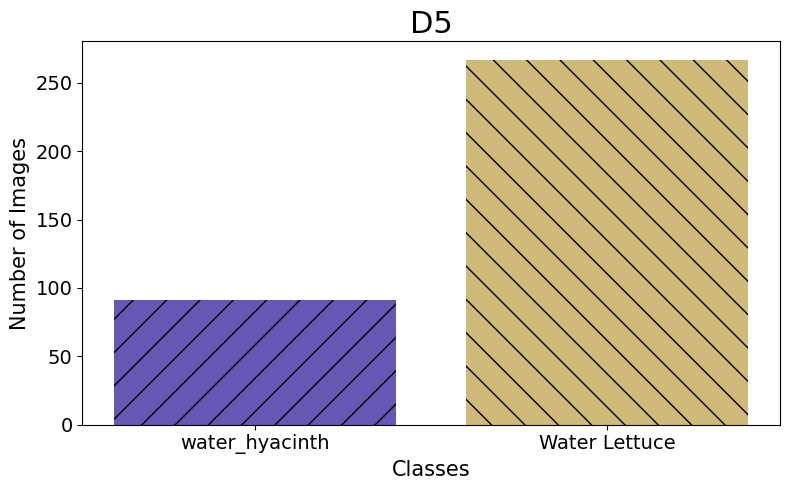

In [12]:


# Define the path to your dataset directory
dataset_path = "/kaggle/working1/sorted_valid"

plt.style.use('default')

# Get the list of categories (subfolder names)
categories = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Count the number of images in each category
image_counts = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]
    image_counts.append(len(image_files))

# Create a dataframe to show the number of images per class
data = pd.DataFrame({"Class": categories, "Number of Images": image_counts})
print(data)


# Create a bar chart to visualize the number of images in each category
plt.figure(figsize=(8, 5))
patterns = ["/", "\\", "|", "-", "+", "x", "o", "*"]  # Define patterns for bars
colors = ["#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in categories]  # Generate unique colors
bars = plt.bar(categories, image_counts, color=colors)
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.title("D5", fontsize=22)
plt.xlabel("Classes", fontsize=15)
plt.ylabel("Number of Images", fontsize=15)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('after_augmentation.png', format='png', dpi=600)
plt.show()


In [13]:
!pip install -q albumentations

# Importing Libraries
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import albumentations as A

# Manually setting the dataset path (you can modify this path as needed)
dataset_path = "/kaggle/working1/sorted_valid"  # Change this to your dataset path

# Defining Dataset Path and Target Count
target_count = 200  # Target count for all classes
valid_ext = ('.jpg', '.jpeg', '.png')

# Defining Augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomCrop(height=224, width=224, p=0.3),
    A.Blur(p=0.2),
    A.GaussNoise(p=0.2),
    A.ColorJitter(p=0.3),
])

# Augmentation Process
for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    # Filtering valid images
    images = [f for f in os.listdir(class_path) if f.lower().endswith(valid_ext)]
    current_count = len(images)

    print(f"Class '{cls}' has {current_count} images.")

    if current_count < target_count:
        # Generate augmented images for underrepresented classes
        to_generate = target_count - current_count
        print(f"Generating {to_generate} augmented images for class '{cls}'...")

        for i in tqdm(range(to_generate)):
            img_name = random.choice(images)
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # If too small for cropping, we resize
            if img.shape[0] < 224 or img.shape[1] < 224:
                img = cv2.resize(img, (256, 256))
            
            # Applying augmentation
            augmented = augmentations(image=img)['image']
            
            # Saving new image with a unique name
            new_img_name = f"aug_{i}_{img_name}"
            save_path = os.path.join(class_path, new_img_name)
            cv2.imwrite(save_path, augmented)
        
    elif current_count > target_count:
        # Randomly select 3500 images for overrepresented classes
        print(f"Class '{cls}' has more than {target_count} images. Selecting 200 images randomly...")
        
        random_images = random.sample(images, target_count)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            if img_name not in random_images:
                os.remove(img_path)  # Removing the image if it is not part of the selected 3500
        
    else:
        print(f"Class '{cls}' already has {target_count} images. No action needed.")

print("Augmentation and pruning complete. All classes now have 200 images.")


Class 'water_hyacinth' has 91 images.
Generating 109 augmented images for class 'water_hyacinth'...


100%|██████████| 109/109 [00:01<00:00, 103.98it/s]

Class 'Water Lettuce' has 267 images.
Class 'Water Lettuce' has more than 200 images. Selecting 200 images randomly...
Augmentation and pruning complete. All classes now have 200 images.


            Class  Number of Images
0  water_hyacinth               200
1   Water Lettuce               200


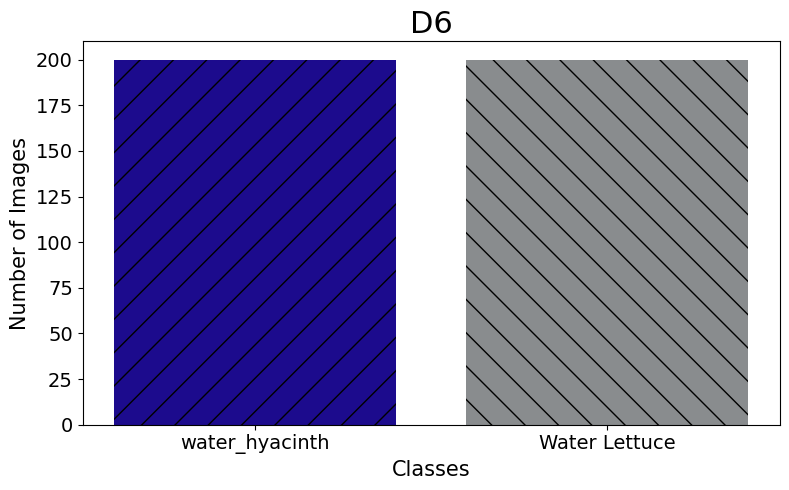

In [14]:


# Define the path to your dataset directory
dataset_path = "/kaggle/working1/sorted_valid"

plt.style.use('default')

# Get the list of categories (subfolder names)
categories = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Count the number of images in each category
image_counts = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]
    image_counts.append(len(image_files))

# Create a dataframe to show the number of images per class
data = pd.DataFrame({"Class": categories, "Number of Images": image_counts})
print(data)


# Create a bar chart to visualize the number of images in each category
plt.figure(figsize=(8, 5))
patterns = ["/", "\\", "|", "-", "+", "x", "o", "*"]  # Define patterns for bars
colors = ["#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in categories]  # Generate unique colors
bars = plt.bar(categories, image_counts, color=colors)
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.title("D6", fontsize=22)
plt.xlabel("Classes", fontsize=15)
plt.ylabel("Number of Images", fontsize=15)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('after_augmentation.png', format='png', dpi=600)
plt.show()


In [15]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transformations (e.g., resizing, tensor conversion, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the desired input size
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
])

# Paths to your dataset directories
train_dataset_path = "/kaggle/working1/sorted_train"  # Path to the training images
val_dataset_path = "/kaggle/working1/sorted_valid"  # Path to the validation images
test_dataset_path = "/kaggle/working1/sorted_test"  # Path to the test images

# Use ImageFolder to load datasets (ensure images are organized into subfolders for each class)
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dataset_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)

# Create DataLoader instances for batching, shuffling, and loading data efficiently
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)


In [16]:
# Model setup
if not torch.cuda.is_available():
    raise RuntimeError('CUDA device is not available. Please ensure a GPU is available to train the model.')
device = torch.device('cuda')
device

device(type='cuda')

# MobileNetV1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example label mapping
label_mapping = ['class_1', 'class_2']
num_classes = len(label_mapping)

# Load the pretrained MobileNet-V1 model from torchvision
model = models.mobilenet_v1(pretrained=True)  # Note: torchvision doesn't have mobilenet_v1, using v2

# Get the number of input features from the original classifier
num_ftrs = model.classifier[1].in_features

# Replace the classifier with a new one
model.classifier = nn.Sequential(
   nn.Linear(num_ftrs, 512),
   nn.ReLU(),
   nn.Dropout(0.4),
   nn.Linear(512, num_classes),
   nn.LogSoftmax(dim=1)
)

# Move the model to the specified device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("MobileNet model initialized and ready for training!")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 121MB/s]


MobileNet model initialized and ready for training!


Epoch 1/30
----------


Train Loss: 0.1788, Train Acc: 0.9404
Val Loss: 0.1162, Val Acc: 0.9525
Epoch 2/30
----------


Train Loss: 0.0997, Train Acc: 0.9654
Val Loss: 0.1153, Val Acc: 0.9400
Epoch 3/30
----------


Train Loss: 0.0906, Train Acc: 0.9700
Val Loss: 0.1076, Val Acc: 0.9675
Epoch 4/30
----------


Train Loss: 0.0892, Train Acc: 0.9726
Val Loss: 0.2456, Val Acc: 0.9100
Epoch 5/30
----------


Train Loss: 0.0609, Train Acc: 0.9800
Val Loss: 0.0869, Val Acc: 0.9675
Epoch 6/30
----------


Train Loss: 0.0588, Train Acc: 0.9813
Val Loss: 0.0972, Val Acc: 0.9725
Epoch 7/30
----------


Train Loss: 0.0527, Train Acc: 0.9816
Val Loss: 0.0752, Val Acc: 0.9725
Epoch 8/30
----------


Train Loss: 0.0562, Train Acc: 0.9826
Val Loss: 0.2078, Val Acc: 0.9575
Epoch 9/30
----------


Train Loss: 0.0487, Train Acc: 0.9849
Val Loss: 0.6188, Val Acc: 0.8525
Epoch 10/30
----------


Train Loss: 0.0561, Train Acc: 0.9819
Val Loss: 0.5017, Val Acc: 0.9100
Epoch 11/30
----------


Train Loss: 0.0516, Train Acc: 0.9846
Val Loss: 0.1724, Val Acc: 0.9600
Epoch 12/30
----------


Train Loss: 0.0362, Train Acc: 0.9866
Val Loss: 0.3309, Val Acc: 0.9400
Epoch 13/30
----------


Train Loss: 0.0224, Train Acc: 0.9927
Val Loss: 0.3744, Val Acc: 0.9275
Epoch 14/30
----------


Train Loss: 0.0382, Train Acc: 0.9864
Val Loss: 0.1786, Val Acc: 0.9425
Epoch 15/30
----------


Train Loss: 0.0340, Train Acc: 0.9874
Val Loss: 0.2328, Val Acc: 0.9600
Epoch 16/30
----------


Train Loss: 0.0254, Train Acc: 0.9911
Val Loss: 0.3176, Val Acc: 0.9175
Epoch 17/30
----------


Train Loss: 0.0404, Train Acc: 0.9871
Val Loss: 0.8933, Val Acc: 0.9200
Epoch 18/30
----------


Train Loss: 0.0645, Train Acc: 0.9807
Val Loss: 0.6140, Val Acc: 0.8675
Epoch 19/30
----------


Train Loss: 0.0249, Train Acc: 0.9906
Val Loss: 1.2925, Val Acc: 0.8975
Epoch 20/30
----------


Train Loss: 0.0300, Train Acc: 0.9901
Val Loss: 0.5528, Val Acc: 0.9475
Epoch 21/30
----------


Train Loss: 0.0171, Train Acc: 0.9953
Val Loss: 2.0477, Val Acc: 0.7625
Epoch 22/30
----------


Train Loss: 0.0159, Train Acc: 0.9947
Val Loss: 7.5495, Val Acc: 0.6575
Epoch 23/30
----------


Train Loss: 0.0282, Train Acc: 0.9914
Val Loss: 0.3351, Val Acc: 0.9375
Epoch 24/30
----------


Train Loss: 0.0281, Train Acc: 0.9911
Val Loss: 0.0774, Val Acc: 0.9725
Epoch 25/30
----------


Train Loss: 0.0268, Train Acc: 0.9911
Val Loss: 0.5467, Val Acc: 0.9125
Epoch 26/30
----------


Train Loss: 0.0245, Train Acc: 0.9924
Val Loss: 14.6343, Val Acc: 0.5875
Epoch 27/30
----------


Train Loss: 0.0208, Train Acc: 0.9924
Val Loss: 1.5854, Val Acc: 0.7425
Epoch 28/30
----------


Train Loss: 0.0479, Train Acc: 0.9879
Val Loss: 31.8118, Val Acc: 0.4575
Epoch 29/30
----------


Train Loss: 0.0141, Train Acc: 0.9953
Val Loss: 0.3206, Val Acc: 0.9625
Epoch 30/30
----------


Train Loss: 0.0229, Train Acc: 0.9914
Val Loss: 195.3959, Val Acc: 0.5000


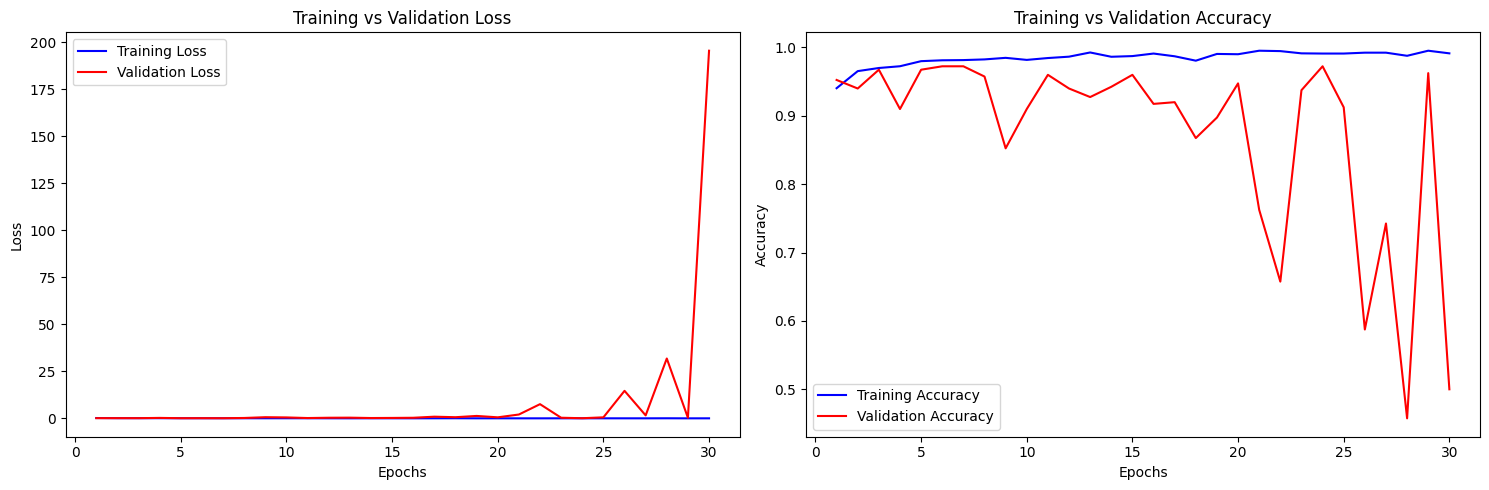

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
   model.train()
   train_losses = []
   train_accuracies = []
   val_losses = []
   val_accuracies = []
   
   for epoch in range(num_epochs):
       model.train()
       print(f'Epoch {epoch+1}/{num_epochs}')
       print('-' * 10)
       running_loss = 0.0
       correct = 0
       total = 0
       
       for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc='Training', leave=False)):
           inputs, labels = inputs.to(device), labels.to(device)
           
           optimizer.zero_grad()
           
           # Mixed precision training
           if device.type == 'cuda':
               with torch.cuda.amp.autocast():
                   outputs = model(inputs)
                   loss = criterion(outputs, labels)
           else:
               outputs = model(inputs)
               loss = criterion(outputs, labels)
           
           loss.backward()
           optimizer.step()
           
           running_loss += loss.item() * inputs.size(0)
           _, predicted = torch.max(outputs, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()
           
           # Memory cleanup every 50 batches
           if batch_idx % 50 == 0 and device.type == 'cuda':
               torch.cuda.empty_cache()
       
       epoch_loss = running_loss / len(train_loader.dataset)
       epoch_acc = correct / total
       train_losses.append(epoch_loss)
       train_accuracies.append(epoch_acc)
       
       # Validation phase
       model.eval()
       val_running_loss = 0.0
       val_correct = 0
       val_total = 0
       
       with torch.no_grad():
           for inputs, labels in val_loader:
               inputs, labels = inputs.to(device), labels.to(device)
               
               if device.type == 'cuda':
                   with torch.cuda.amp.autocast():
                       outputs = model(inputs)
                       loss = criterion(outputs, labels)
               else:
                   outputs = model(inputs)
                   loss = criterion(outputs, labels)
               
               val_running_loss += loss.item() * inputs.size(0)
               _, predicted = torch.max(outputs, 1)
               val_total += labels.size(0)
               val_correct += (predicted == labels).sum().item()
       
       val_loss = val_running_loss / len(val_loader.dataset)
       val_acc = val_correct / val_total
       val_losses.append(val_loss)
       val_accuracies.append(val_acc)
       
       print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
       print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
       
       # Memory cleanup after each epoch
       if device.type == 'cuda':
           torch.cuda.empty_cache()
   
   # Plot learning curves
   plt.figure(figsize=(15, 5))
   
   plt.subplot(1, 2, 1)
   plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
   plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.title('Training vs Validation Loss')
   plt.legend()
   
   plt.subplot(1, 2, 2)
   plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy')
   plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Validation Accuracy')
   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   plt.title('Training vs Validation Accuracy')
   plt.legend()
   
   plt.tight_layout()
   plt.show()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

# MobileNetV2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example label mapping
label_mapping = ['class_1', 'class_2']
num_classes = len(label_mapping)

# Load the pretrained MobileNet-V2 model from torchvision
model2 = models.mobilenet_v2(pretrained=True)

# Get the number of input features from the original classifier
num_ftrs = model2.classifier[1].in_features

# Replace the classifier with a new one
model2.classifier = nn.Sequential(
   nn.Linear(num_ftrs, 512),
   nn.ReLU(),
   nn.Dropout(0.4),
   nn.Linear(512, num_classes),
   nn.LogSoftmax(dim=1)
)

# Move the model to the specified device
model2 = model2.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

print("Model2 (MobileNet-V2) initialized and ready for training!")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Model2 (MobileNet-V2) initialized and ready for training!


Epoch 1/30
----------


Train Loss: 0.1893, Train Acc: 0.9327
Val Loss: 0.0920, Val Acc: 0.9675
Epoch 2/30
----------


Train Loss: 0.1170, Train Acc: 0.9629
Val Loss: 0.1360, Val Acc: 0.9200
Epoch 3/30
----------


Train Loss: 0.0902, Train Acc: 0.9713
Val Loss: 0.0601, Val Acc: 0.9750
Epoch 4/30
----------


Train Loss: 0.0723, Train Acc: 0.9757
Val Loss: 0.0712, Val Acc: 0.9625
Epoch 5/30
----------


Train Loss: 0.0590, Train Acc: 0.9794
Val Loss: 0.0812, Val Acc: 0.9700
Epoch 6/30
----------


Train Loss: 0.0620, Train Acc: 0.9806
Val Loss: 0.0905, Val Acc: 0.9725
Epoch 7/30
----------


Train Loss: 0.0404, Train Acc: 0.9851
Val Loss: 0.0989, Val Acc: 0.9775
Epoch 8/30
----------


Train Loss: 0.0625, Train Acc: 0.9781
Val Loss: 0.1417, Val Acc: 0.9575
Epoch 9/30
----------


Train Loss: 0.0438, Train Acc: 0.9851
Val Loss: 0.1127, Val Acc: 0.9525
Epoch 10/30
----------


Train Loss: 0.0414, Train Acc: 0.9873
Val Loss: 0.1142, Val Acc: 0.9600
Epoch 11/30
----------


Train Loss: 0.0391, Train Acc: 0.9850
Val Loss: 0.2530, Val Acc: 0.9300
Epoch 12/30
----------


Train Loss: 0.0438, Train Acc: 0.9857
Val Loss: 0.0943, Val Acc: 0.9700
Epoch 13/30
----------


Train Loss: 0.0382, Train Acc: 0.9870
Val Loss: 0.1380, Val Acc: 0.9700
Epoch 14/30
----------


Train Loss: 0.0353, Train Acc: 0.9879
Val Loss: 0.2879, Val Acc: 0.9525
Epoch 15/30
----------


Train Loss: 0.0304, Train Acc: 0.9901
Val Loss: 1.0309, Val Acc: 0.9075
Epoch 16/30
----------


Train Loss: 0.0398, Train Acc: 0.9864
Val Loss: 0.9419, Val Acc: 0.9250
Epoch 17/30
----------


Train Loss: 0.0249, Train Acc: 0.9931
Val Loss: 8.4893, Val Acc: 0.5125
Epoch 18/30
----------


Train Loss: 0.0362, Train Acc: 0.9884
Val Loss: 0.3692, Val Acc: 0.9325
Epoch 19/30
----------


Train Loss: 0.0376, Train Acc: 0.9891
Val Loss: 0.1644, Val Acc: 0.9425
Epoch 20/30
----------


Train Loss: 0.0465, Train Acc: 0.9870
Val Loss: 0.1254, Val Acc: 0.9550
Epoch 21/30
----------


Train Loss: 0.0243, Train Acc: 0.9914
Val Loss: 0.2759, Val Acc: 0.9075
Epoch 22/30
----------


Train Loss: 0.0258, Train Acc: 0.9919
Val Loss: 0.8418, Val Acc: 0.9450
Epoch 23/30
----------


Train Loss: 0.0185, Train Acc: 0.9934
Val Loss: 12.4351, Val Acc: 0.5800
Epoch 24/30
----------


Train Loss: 0.0187, Train Acc: 0.9937
Val Loss: 0.4267, Val Acc: 0.9575
Epoch 25/30
----------


Train Loss: 0.0256, Train Acc: 0.9936
Val Loss: 7.7929, Val Acc: 0.5000
Epoch 26/30
----------


Train Loss: 0.0305, Train Acc: 0.9893
Val Loss: 2.5320, Val Acc: 0.8600
Epoch 27/30
----------


Train Loss: 0.0398, Train Acc: 0.9901
Val Loss: 0.7469, Val Acc: 0.8925
Epoch 28/30
----------


Train Loss: 0.0247, Train Acc: 0.9924
Val Loss: 9.0406, Val Acc: 0.4975
Epoch 29/30
----------


Train Loss: 0.0204, Train Acc: 0.9940
Val Loss: 0.6577, Val Acc: 0.9425
Epoch 30/30
----------


Train Loss: 0.0220, Train Acc: 0.9930
Val Loss: 22.2594, Val Acc: 0.5500


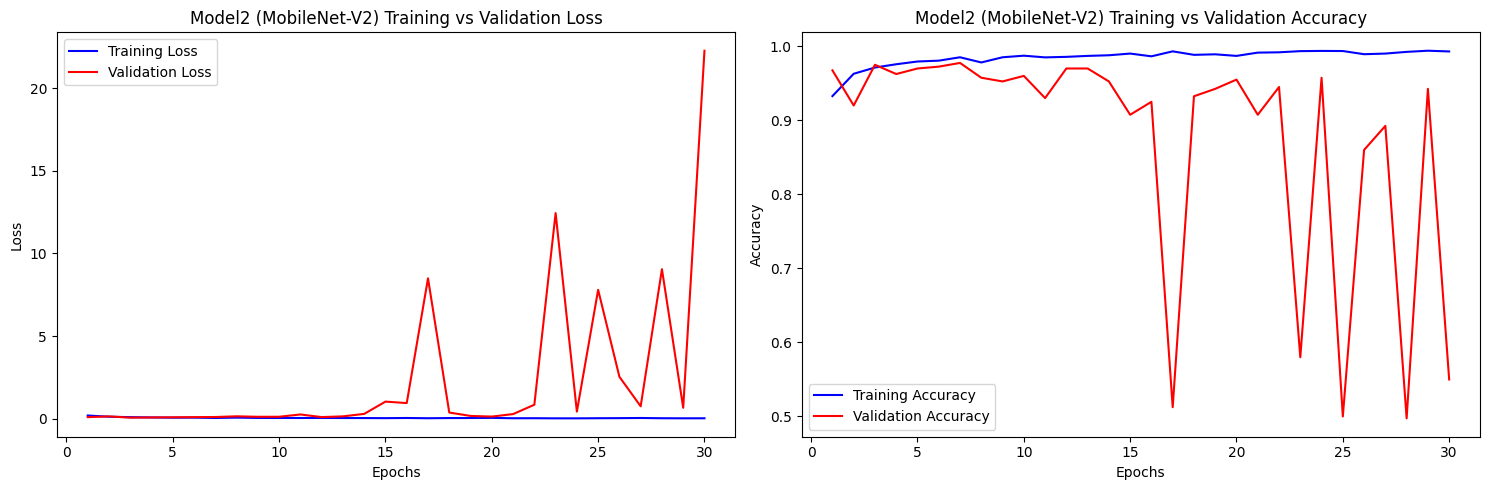

In [20]:
def train_model2(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
   model.train()
   train_losses = []
   train_accuracies = []
   val_losses = []
   val_accuracies = []
   
   for epoch in range(num_epochs):
       model.train()
       print(f'Epoch {epoch+1}/{num_epochs}')
       print('-' * 10)
       running_loss = 0.0
       correct = 0
       total = 0
       
       for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc='Training', leave=False)):
           inputs, labels = inputs.to(device), labels.to(device)
           
           optimizer.zero_grad()
           
           # Mixed precision training
           if device.type == 'cuda':
               with torch.cuda.amp.autocast():
                   outputs = model(inputs)
                   loss = criterion(outputs, labels)
           else:
               outputs = model(inputs)
               loss = criterion(outputs, labels)
           
           loss.backward()
           optimizer.step()
           
           running_loss += loss.item() * inputs.size(0)
           _, predicted = torch.max(outputs, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()
           
           # Memory cleanup every 50 batches
           if batch_idx % 50 == 0 and device.type == 'cuda':
               torch.cuda.empty_cache()
       
       epoch_loss = running_loss / len(train_loader.dataset)
       epoch_acc = correct / total
       train_losses.append(epoch_loss)
       train_accuracies.append(epoch_acc)
       
       # Validation phase
       model.eval()
       val_running_loss = 0.0
       val_correct = 0
       val_total = 0
       
       with torch.no_grad():
           for inputs, labels in val_loader:
               inputs, labels = inputs.to(device), labels.to(device)
               
               if device.type == 'cuda':
                   with torch.cuda.amp.autocast():
                       outputs = model(inputs)
                       loss = criterion(outputs, labels)
               else:
                   outputs = model(inputs)
                   loss = criterion(outputs, labels)
               
               val_running_loss += loss.item() * inputs.size(0)
               _, predicted = torch.max(outputs, 1)
               val_total += labels.size(0)
               val_correct += (predicted == labels).sum().item()
       
       val_loss = val_running_loss / len(val_loader.dataset)
       val_acc = val_correct / val_total
       val_losses.append(val_loss)
       val_accuracies.append(val_acc)
       
       print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
       print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
       
       # Memory cleanup after each epoch
       if device.type == 'cuda':
           torch.cuda.empty_cache()
   
   # Plot learning curves
   plt.figure(figsize=(15, 5))
   
   plt.subplot(1, 2, 1)
   plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
   plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.title('Model2 (MobileNet-V2) Training vs Validation Loss')
   plt.legend()
   
   plt.subplot(1, 2, 2)
   plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy')
   plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Validation Accuracy')
   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   plt.title('Model2 (MobileNet-V2) Training vs Validation Accuracy')
   plt.legend()
   
   plt.tight_layout()
   plt.show()

# Train model2 (MobileNet-V2)
train_model2(model2, train_loader, val_loader, criterion, optimizer2, num_epochs=30)

# ShuffleNetV2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example label mapping
label_mapping = ['class_1', 'class_2']
num_classes = len(label_mapping)

# Load the pretrained ShuffleNet-V2 model from torchvision
model3 = models.shufflenet_v2_x1_0(pretrained=True)  # Note: torchvision doesn't have shufflenet_v1, using v2

# Get the number of input features from the original classifier
num_ftrs = model3.fc.in_features

# Replace the classifier with a new one
model3.fc = nn.Sequential(
   nn.Linear(num_ftrs, 512),
   nn.ReLU(),
   nn.Dropout(0.4),
   nn.Linear(512, num_classes),
   nn.LogSoftmax(dim=1)
)

# Move the model to the specified device
model3 = model3.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

print("Model3 (ShuffleNet-V2) initialized and ready for training!")

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 94.8MB/s]

Model3 (ShuffleNet-V2) initialized and ready for training!


Epoch 1/30
----------


Train Loss: 0.1451, Train Acc: 0.9521
Val Loss: 0.0833, Val Acc: 0.9750
Epoch 2/30
----------


Train Loss: 0.0604, Train Acc: 0.9803
Val Loss: 0.1272, Val Acc: 0.9600
Epoch 3/30
----------


Train Loss: 0.0450, Train Acc: 0.9857
Val Loss: 0.0590, Val Acc: 0.9775
Epoch 4/30
----------


Train Loss: 0.0315, Train Acc: 0.9897
Val Loss: 0.0426, Val Acc: 0.9875
Epoch 5/30
----------


Train Loss: 0.0352, Train Acc: 0.9889
Val Loss: 0.0913, Val Acc: 0.9725
Epoch 6/30
----------


Train Loss: 0.0218, Train Acc: 0.9931
Val Loss: 0.1200, Val Acc: 0.9725
Epoch 7/30
----------


Train Loss: 0.0257, Train Acc: 0.9923
Val Loss: 0.0748, Val Acc: 0.9800
Epoch 8/30
----------


Train Loss: 0.0165, Train Acc: 0.9951
Val Loss: 0.1228, Val Acc: 0.9675
Epoch 9/30
----------


Train Loss: 0.0179, Train Acc: 0.9951
Val Loss: 0.0937, Val Acc: 0.9825
Epoch 10/30
----------


Train Loss: 0.0137, Train Acc: 0.9943
Val Loss: 0.2540, Val Acc: 0.9550
Epoch 11/30
----------


Train Loss: 0.0168, Train Acc: 0.9937
Val Loss: 0.0822, Val Acc: 0.9825
Epoch 12/30
----------


Train Loss: 0.0192, Train Acc: 0.9943
Val Loss: 0.2188, Val Acc: 0.9625
Epoch 13/30
----------


Train Loss: 0.0374, Train Acc: 0.9914
Val Loss: 0.0368, Val Acc: 0.9875
Epoch 14/30
----------


Train Loss: 0.0139, Train Acc: 0.9959
Val Loss: 0.1621, Val Acc: 0.9600
Epoch 15/30
----------


Train Loss: 0.0177, Train Acc: 0.9947
Val Loss: 0.2699, Val Acc: 0.9400
Epoch 16/30
----------


Train Loss: 0.0109, Train Acc: 0.9969
Val Loss: 0.1920, Val Acc: 0.9525
Epoch 17/30
----------


Train Loss: 0.0109, Train Acc: 0.9971
Val Loss: 0.1270, Val Acc: 0.9775
Epoch 18/30
----------


Train Loss: 0.0247, Train Acc: 0.9937
Val Loss: 0.1011, Val Acc: 0.9750
Epoch 19/30
----------


Train Loss: 0.0105, Train Acc: 0.9967
Val Loss: 0.1522, Val Acc: 0.9525
Epoch 20/30
----------


Train Loss: 0.0084, Train Acc: 0.9969
Val Loss: 0.1097, Val Acc: 0.9775
Epoch 21/30
----------


Train Loss: 0.0089, Train Acc: 0.9966
Val Loss: 0.2451, Val Acc: 0.9550
Epoch 22/30
----------


Train Loss: 0.0029, Train Acc: 0.9989
Val Loss: 0.3025, Val Acc: 0.9500
Epoch 23/30
----------


Train Loss: 0.0170, Train Acc: 0.9941
Val Loss: 0.1435, Val Acc: 0.9750
Epoch 24/30
----------


Train Loss: 0.0120, Train Acc: 0.9957
Val Loss: 0.4452, Val Acc: 0.9350
Epoch 25/30
----------


Train Loss: 0.0049, Train Acc: 0.9981
Val Loss: 0.2432, Val Acc: 0.9650
Epoch 26/30
----------


Train Loss: 0.0020, Train Acc: 0.9993
Val Loss: 0.0860, Val Acc: 0.9850
Epoch 27/30
----------


Train Loss: 0.0195, Train Acc: 0.9936
Val Loss: 0.3418, Val Acc: 0.9600
Epoch 28/30
----------


Train Loss: 0.0140, Train Acc: 0.9959
Val Loss: 0.1229, Val Acc: 0.9775
Epoch 29/30
----------


Train Loss: 0.0028, Train Acc: 0.9993
Val Loss: 0.9229, Val Acc: 0.8950
Epoch 30/30
----------


Train Loss: 0.0016, Train Acc: 0.9994
Val Loss: 0.1527, Val Acc: 0.9775


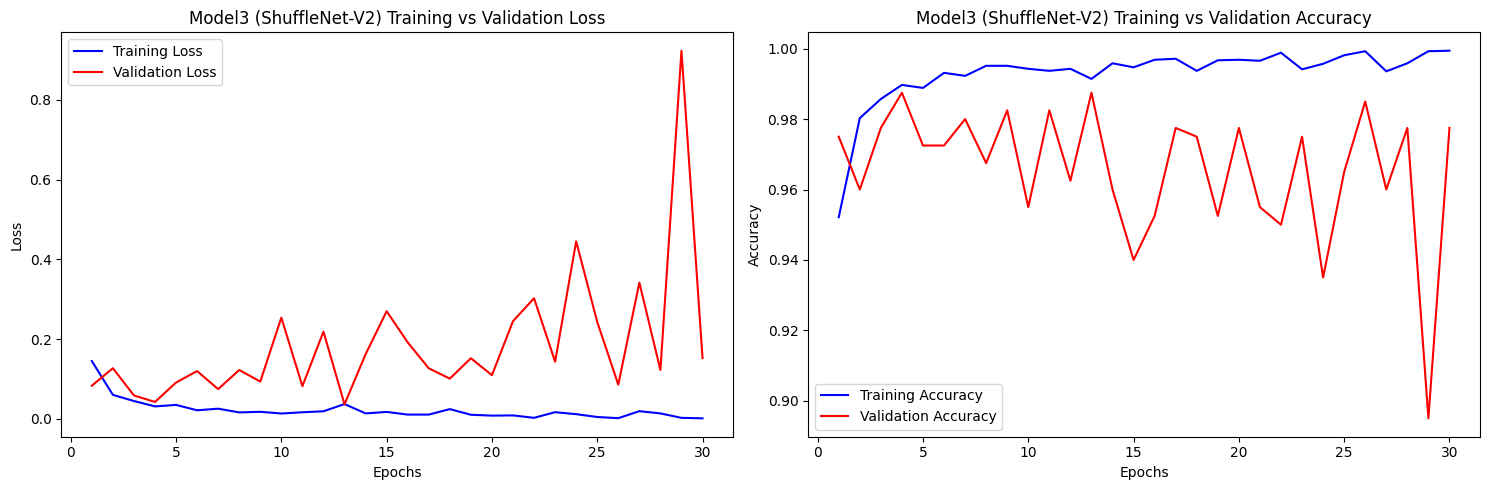

In [22]:
def train_model3(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
   model.train()
   train_losses = []
   train_accuracies = []
   val_losses = []
   val_accuracies = []
   
   for epoch in range(num_epochs):
       model.train()
       print(f'Epoch {epoch+1}/{num_epochs}')
       print('-' * 10)
       running_loss = 0.0
       correct = 0
       total = 0
       
       for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc='Training', leave=False)):
           inputs, labels = inputs.to(device), labels.to(device)
           
           optimizer.zero_grad()
           
           # Mixed precision training
           if device.type == 'cuda':
               with torch.cuda.amp.autocast():
                   outputs = model(inputs)
                   loss = criterion(outputs, labels)
           else:
               outputs = model(inputs)
               loss = criterion(outputs, labels)
           
           loss.backward()
           optimizer.step()
           
           running_loss += loss.item() * inputs.size(0)
           _, predicted = torch.max(outputs, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()
           
           # Memory cleanup every 50 batches
           if batch_idx % 50 == 0 and device.type == 'cuda':
               torch.cuda.empty_cache()
       
       epoch_loss = running_loss / len(train_loader.dataset)
       epoch_acc = correct / total
       train_losses.append(epoch_loss)
       train_accuracies.append(epoch_acc)
       
       # Validation phase
       model.eval()
       val_running_loss = 0.0
       val_correct = 0
       val_total = 0
       
       with torch.no_grad():
           for inputs, labels in val_loader:
               inputs, labels = inputs.to(device), labels.to(device)
               
               if device.type == 'cuda':
                   with torch.cuda.amp.autocast():
                       outputs = model(inputs)
                       loss = criterion(outputs, labels)
               else:
                   outputs = model(inputs)
                   loss = criterion(outputs, labels)
               
               val_running_loss += loss.item() * inputs.size(0)
               _, predicted = torch.max(outputs, 1)
               val_total += labels.size(0)
               val_correct += (predicted == labels).sum().item()
       
       val_loss = val_running_loss / len(val_loader.dataset)
       val_acc = val_correct / val_total
       val_losses.append(val_loss)
       val_accuracies.append(val_acc)
       
       print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
       print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
       
       # Memory cleanup after each epoch
       if device.type == 'cuda':
           torch.cuda.empty_cache()
   
   # Plot learning curves
   plt.figure(figsize=(15, 5))
   
   plt.subplot(1, 2, 1)
   plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
   plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.title('Model3 (ShuffleNet-V2) Training vs Validation Loss')
   plt.legend()
   
   plt.subplot(1, 2, 2)
   plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy')
   plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Validation Accuracy')
   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   plt.title('Model3 (ShuffleNet-V2) Training vs Validation Accuracy')
   plt.legend()
   
   plt.tight_layout()
   plt.show()

# Train model3 (ShuffleNet-V2)
train_model3(model3, train_loader, val_loader, criterion, optimizer3, num_epochs=30)

# SqueezNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example label mapping
label_mapping = ['class_1', 'class_2']
num_classes = len(label_mapping)

# Load the pretrained SqueezeNet model from torchvision
model4 = models.squeezenet1_1(pretrained=True)

# Get the number of input features from the original classifier
# SqueezeNet has a different structure - it uses conv layers in classifier
model4.classifier = nn.Sequential(
   nn.Dropout(0.5),
   nn.Conv2d(512, num_classes, kernel_size=1),
   nn.ReLU(inplace=True),
   nn.AdaptiveAvgPool2d((1, 1)),
   nn.Flatten(),
   nn.LogSoftmax(dim=1)
)

# Move the model to the specified device
model4 = model4.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer4 = optim.Adam(model4.parameters(), lr=0.001)

print("Model4 (SqueezeNet) initialized and ready for training!")

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 67.8MB/s]

Model4 (SqueezeNet) initialized and ready for training!


Epoch 1/30
----------


Train Loss: 0.3311, Train Acc: 0.8680
Val Loss: 0.2531, Val Acc: 0.9075
Epoch 2/30
----------


Train Loss: 0.1892, Train Acc: 0.9301
Val Loss: 0.3325, Val Acc: 0.9050
Epoch 3/30
----------


Train Loss: 0.1711, Train Acc: 0.9359
Val Loss: 0.2236, Val Acc: 0.9350
Epoch 4/30
----------


Train Loss: 0.1617, Train Acc: 0.9394
Val Loss: 0.1801, Val Acc: 0.9425
Epoch 5/30
----------


Train Loss: 0.1350, Train Acc: 0.9530
Val Loss: 0.1934, Val Acc: 0.9475
Epoch 6/30
----------


Train Loss: 0.1194, Train Acc: 0.9557
Val Loss: 0.2005, Val Acc: 0.9275
Epoch 7/30
----------


Train Loss: 0.1053, Train Acc: 0.9629
Val Loss: 0.1991, Val Acc: 0.9375
Epoch 8/30
----------


Train Loss: 0.1039, Train Acc: 0.9664
Val Loss: 0.1279, Val Acc: 0.9525
Epoch 9/30
----------


Train Loss: 0.0986, Train Acc: 0.9674
Val Loss: 0.2132, Val Acc: 0.9225
Epoch 10/30
----------


Train Loss: 0.0767, Train Acc: 0.9730
Val Loss: 0.1121, Val Acc: 0.9550
Epoch 11/30
----------


Train Loss: 0.0778, Train Acc: 0.9739
Val Loss: 0.1832, Val Acc: 0.9350
Epoch 12/30
----------


Train Loss: 0.0815, Train Acc: 0.9716
Val Loss: 0.1836, Val Acc: 0.9550
Epoch 13/30
----------


Train Loss: 0.0519, Train Acc: 0.9821
Val Loss: 0.2661, Val Acc: 0.9475
Epoch 14/30
----------


Train Loss: 0.0556, Train Acc: 0.9797
Val Loss: 0.1602, Val Acc: 0.9575
Epoch 15/30
----------


Train Loss: 0.0501, Train Acc: 0.9817
Val Loss: 0.2243, Val Acc: 0.9450
Epoch 16/30
----------


Train Loss: 0.0395, Train Acc: 0.9857
Val Loss: 0.1382, Val Acc: 0.9525
Epoch 17/30
----------


Train Loss: 0.0493, Train Acc: 0.9829
Val Loss: 0.2358, Val Acc: 0.9350
Epoch 18/30
----------


Train Loss: 0.0508, Train Acc: 0.9823
Val Loss: 0.1416, Val Acc: 0.9575
Epoch 19/30
----------


Train Loss: 0.0565, Train Acc: 0.9814
Val Loss: 0.1134, Val Acc: 0.9650
Epoch 20/30
----------


Train Loss: 0.0379, Train Acc: 0.9887
Val Loss: 0.1432, Val Acc: 0.9600
Epoch 21/30
----------


Train Loss: 0.0395, Train Acc: 0.9874
Val Loss: 0.2131, Val Acc: 0.9550
Epoch 22/30
----------


Train Loss: 0.0326, Train Acc: 0.9904
Val Loss: 0.2474, Val Acc: 0.9600
Epoch 23/30
----------


Train Loss: 0.0314, Train Acc: 0.9893
Val Loss: 0.2120, Val Acc: 0.9500
Epoch 24/30
----------


Train Loss: 0.0363, Train Acc: 0.9877
Val Loss: 0.2256, Val Acc: 0.9575
Epoch 25/30
----------


Train Loss: 0.0268, Train Acc: 0.9904
Val Loss: 0.1308, Val Acc: 0.9625
Epoch 26/30
----------


Train Loss: 0.0343, Train Acc: 0.9877
Val Loss: 0.2291, Val Acc: 0.9275
Epoch 27/30
----------


Train Loss: 0.0329, Train Acc: 0.9886
Val Loss: 0.1191, Val Acc: 0.9625
Epoch 28/30
----------


Train Loss: 0.0424, Train Acc: 0.9869
Val Loss: 0.1885, Val Acc: 0.9400
Epoch 29/30
----------


Train Loss: 0.0170, Train Acc: 0.9951
Val Loss: 0.3025, Val Acc: 0.9575
Epoch 30/30
----------


Train Loss: 0.0261, Train Acc: 0.9910
Val Loss: 0.1713, Val Acc: 0.9475


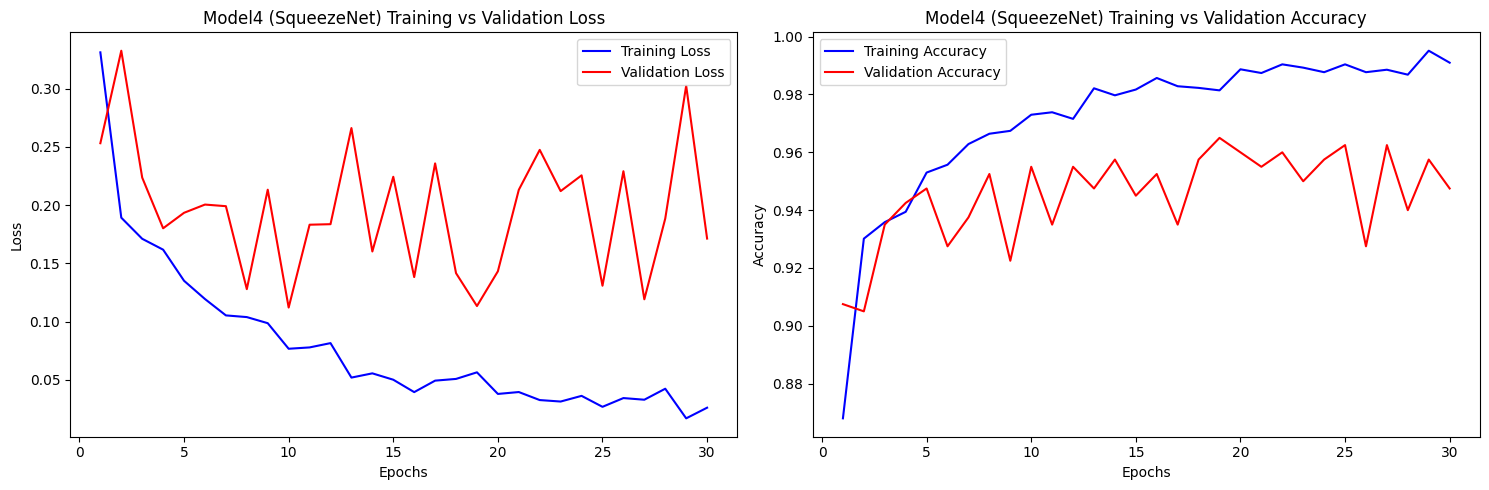

In [24]:
def train_model4(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
   model.train()
   train_losses = []
   train_accuracies = []
   val_losses = []
   val_accuracies = []
   
   for epoch in range(num_epochs):
       model.train()
       print(f'Epoch {epoch+1}/{num_epochs}')
       print('-' * 10)
       running_loss = 0.0
       correct = 0
       total = 0
       
       for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc='Training', leave=False)):
           inputs, labels = inputs.to(device), labels.to(device)
           
           optimizer.zero_grad()
           
           # Mixed precision training
           if device.type == 'cuda':
               with torch.cuda.amp.autocast():
                   outputs = model(inputs)
                   loss = criterion(outputs, labels)
           else:
               outputs = model(inputs)
               loss = criterion(outputs, labels)
           
           loss.backward()
           optimizer.step()
           
           running_loss += loss.item() * inputs.size(0)
           _, predicted = torch.max(outputs, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()
           
           # Memory cleanup every 50 batches
           if batch_idx % 50 == 0 and device.type == 'cuda':
               torch.cuda.empty_cache()
       
       epoch_loss = running_loss / len(train_loader.dataset)
       epoch_acc = correct / total
       train_losses.append(epoch_loss)
       train_accuracies.append(epoch_acc)
       
       # Validation phase
       model.eval()
       val_running_loss = 0.0
       val_correct = 0
       val_total = 0
       
       with torch.no_grad():
           for inputs, labels in val_loader:
               inputs, labels = inputs.to(device), labels.to(device)
               
               if device.type == 'cuda':
                   with torch.cuda.amp.autocast():
                       outputs = model(inputs)
                       loss = criterion(outputs, labels)
               else:
                   outputs = model(inputs)
                   loss = criterion(outputs, labels)
               
               val_running_loss += loss.item() * inputs.size(0)
               _, predicted = torch.max(outputs, 1)
               val_total += labels.size(0)
               val_correct += (predicted == labels).sum().item()
       
       val_loss = val_running_loss / len(val_loader.dataset)
       val_acc = val_correct / val_total
       val_losses.append(val_loss)
       val_accuracies.append(val_acc)
       
       print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
       print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
       
       # Memory cleanup after each epoch
       if device.type == 'cuda':
           torch.cuda.empty_cache()
   
   # Plot learning curves
   plt.figure(figsize=(15, 5))
   
   plt.subplot(1, 2, 1)
   plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
   plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.title('Model4 (SqueezeNet) Training vs Validation Loss')
   plt.legend()
   
   plt.subplot(1, 2, 2)
   plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy')
   plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Validation Accuracy')
   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   plt.title('Model4 (SqueezeNet) Training vs Validation Accuracy')
   plt.legend()
   
   plt.tight_layout()
   plt.show()

# Train model4 (SqueezeNet)
train_model4(model4, train_loader, val_loader, criterion, optimizer4, num_epochs=30)

In [27]:
!pip install timm


import torch
import torch.nn as nn
import torch.optim as optim
import timm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example label mapping
label_mapping = ['class_1', 'class_2', 'class_3', 'class_4', 'class_5']
num_classes = len(label_mapping)

# Load the pretrained NASNet-A model using timm
# Ensure num_classes is correctly passed
model5 = timm.create_model('nasnetalarge', pretrained=True, num_classes=num_classes)

# Move the model to the specified device
model5 = model5.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer5 = optim.Adam(model5.parameters(), lr=0.001)

print("Model5 (NASNet-A) initialized and ready for training!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

model.safetensors:   0%|          | 0.00/356M [00:00<?, ?B/s]

Model5 (NASNet-A) initialized and ready for training!


Epoch 1/30
----------


Train Loss: 0.2441, Train Acc: 0.9167
Val Loss: 0.2155, Val Acc: 0.9225
Epoch 2/30
----------


Train Loss: 0.1582, Train Acc: 0.9454
Val Loss: 0.1099, Val Acc: 0.9575
Epoch 3/30
----------


Train Loss: 0.1198, Train Acc: 0.9603
Val Loss: 0.1051, Val Acc: 0.9550
Epoch 4/30
----------


Train Loss: 0.0760, Train Acc: 0.9743
Val Loss: 0.0853, Val Acc: 0.9825
Epoch 5/30
----------


Train Loss: 0.0987, Train Acc: 0.9660
Val Loss: 0.2433, Val Acc: 0.9250
Epoch 6/30
----------


Train Loss: 0.0654, Train Acc: 0.9760
Val Loss: 0.1260, Val Acc: 0.9600
Epoch 7/30
----------


Train Loss: 0.0427, Train Acc: 0.9871
Val Loss: 0.0582, Val Acc: 0.9825
Epoch 8/30
----------


Train Loss: 0.0581, Train Acc: 0.9823
Val Loss: 0.2731, Val Acc: 0.9225
Epoch 9/30
----------


Train Loss: 0.0786, Train Acc: 0.9740
Val Loss: 0.2364, Val Acc: 0.9525
Epoch 10/30
----------


Train Loss: 0.0396, Train Acc: 0.9873
Val Loss: 0.1078, Val Acc: 0.9575
Epoch 11/30
----------


Train Loss: 0.0437, Train Acc: 0.9840
Val Loss: 0.0990, Val Acc: 0.9700
Epoch 12/30
----------


Train Loss: 0.0330, Train Acc: 0.9900
Val Loss: 0.1473, Val Acc: 0.9625
Epoch 13/30
----------


Train Loss: 0.0386, Train Acc: 0.9859
Val Loss: 0.0921, Val Acc: 0.9700
Epoch 14/30
----------


Train Loss: 0.0321, Train Acc: 0.9899
Val Loss: 0.0610, Val Acc: 0.9700
Epoch 15/30
----------


Train Loss: 0.0324, Train Acc: 0.9914
Val Loss: 0.1576, Val Acc: 0.9300
Epoch 16/30
----------


Train Loss: 0.0383, Train Acc: 0.9883
Val Loss: 0.1016, Val Acc: 0.9800
Epoch 17/30
----------


Train Loss: 0.0234, Train Acc: 0.9913
Val Loss: 0.1295, Val Acc: 0.9775
Epoch 18/30
----------


Train Loss: 0.0272, Train Acc: 0.9923
Val Loss: 0.6565, Val Acc: 0.9250
Epoch 19/30
----------


Train Loss: 0.0277, Train Acc: 0.9899
Val Loss: 0.1947, Val Acc: 0.9450
Epoch 20/30
----------


Train Loss: 0.0368, Train Acc: 0.9903
Val Loss: 0.0791, Val Acc: 0.9750
Epoch 21/30
----------


Train Loss: 0.0200, Train Acc: 0.9941
Val Loss: 0.1393, Val Acc: 0.9750
Epoch 22/30
----------


Train Loss: 0.0132, Train Acc: 0.9956
Val Loss: 0.1773, Val Acc: 0.9800
Epoch 23/30
----------


Train Loss: 0.0205, Train Acc: 0.9934
Val Loss: 0.1701, Val Acc: 0.9475
Epoch 24/30
----------


Train Loss: 0.0230, Train Acc: 0.9913
Val Loss: 0.3658, Val Acc: 0.9100
Epoch 25/30
----------


Train Loss: 0.0209, Train Acc: 0.9939
Val Loss: 0.3506, Val Acc: 0.9250
Epoch 26/30
----------


Train Loss: 0.0558, Train Acc: 0.9811
Val Loss: 0.2788, Val Acc: 0.9325
Epoch 27/30
----------


Train Loss: 0.0244, Train Acc: 0.9920
Val Loss: 0.2469, Val Acc: 0.9775
Epoch 28/30
----------


Train Loss: 0.0105, Train Acc: 0.9967
Val Loss: 0.1946, Val Acc: 0.9600
Epoch 29/30
----------


Train Loss: 0.0105, Train Acc: 0.9971
Val Loss: 0.1407, Val Acc: 0.9600
Epoch 30/30
----------


Train Loss: 0.0166, Train Acc: 0.9954
Val Loss: 0.1147, Val Acc: 0.9700


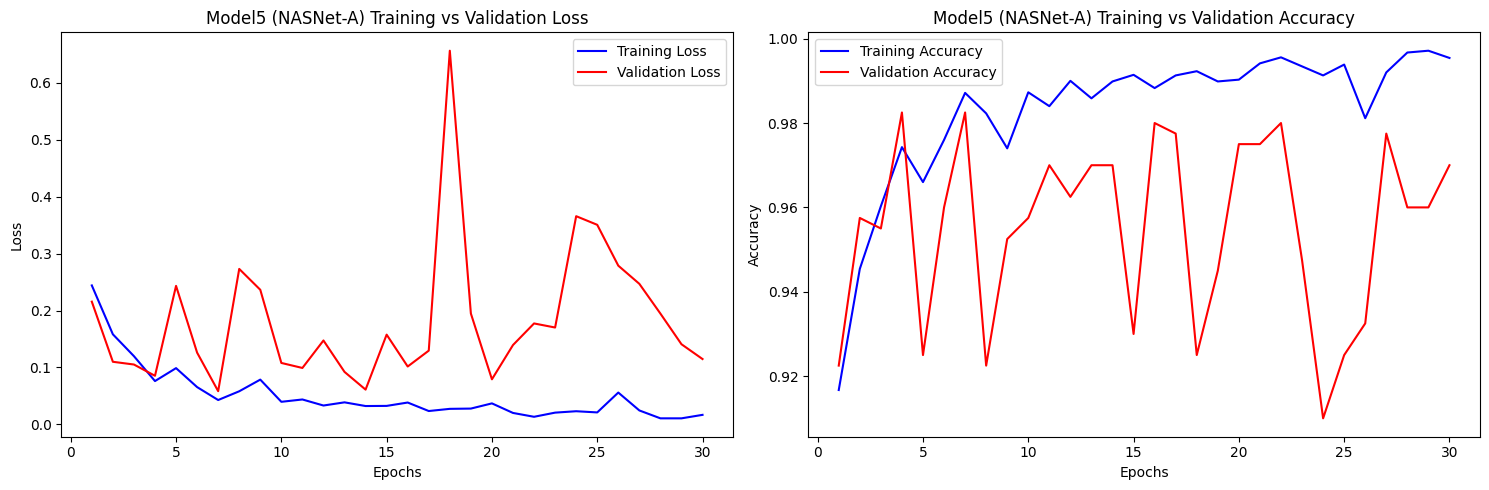

In [28]:
def train_model5(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
   model.train()
   train_losses = []
   train_accuracies = []
   val_losses = []
   val_accuracies = []
   
   for epoch in range(num_epochs):
       model.train()
       print(f'Epoch {epoch+1}/{num_epochs}')
       print('-' * 10)
       running_loss = 0.0
       correct = 0
       total = 0
       
       for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc='Training', leave=False)):
           inputs, labels = inputs.to(device), labels.to(device)
           
           optimizer.zero_grad()
           
           # Mixed precision training
           if device.type == 'cuda':
               with torch.cuda.amp.autocast():
                   outputs = model(inputs)
                   loss = criterion(outputs, labels)
           else:
               outputs = model(inputs)
               loss = criterion(outputs, labels)
           
           loss.backward()
           optimizer.step()
           
           running_loss += loss.item() * inputs.size(0)
           _, predicted = torch.max(outputs, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()
           
           # Memory cleanup every 50 batches
           if batch_idx % 50 == 0 and device.type == 'cuda':
               torch.cuda.empty_cache()
       
       epoch_loss = running_loss / len(train_loader.dataset)
       epoch_acc = correct / total
       train_losses.append(epoch_loss)
       train_accuracies.append(epoch_acc)
       
       # Validation phase
       model.eval()
       val_running_loss = 0.0
       val_correct = 0
       val_total = 0
       
       with torch.no_grad():
           for inputs, labels in val_loader:
               inputs, labels = inputs.to(device), labels.to(device)
               
               if device.type == 'cuda':
                   with torch.cuda.amp.autocast():
                       outputs = model(inputs)
                       loss = criterion(outputs, labels)
               else:
                   outputs = model(inputs)
                   loss = criterion(outputs, labels)
               
               val_running_loss += loss.item() * inputs.size(0)
               _, predicted = torch.max(outputs, 1)
               val_total += labels.size(0)
               val_correct += (predicted == labels).sum().item()
       
       val_loss = val_running_loss / len(val_loader.dataset)
       val_acc = val_correct / val_total
       val_losses.append(val_loss)
       val_accuracies.append(val_acc)
       
       print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
       print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
       
       # Memory cleanup after each epoch
       if device.type == 'cuda':
           torch.cuda.empty_cache()
   
   # Plot learning curves
   plt.figure(figsize=(15, 5))
   
   plt.subplot(1, 2, 1)
   plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
   plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.title('Model5 (NASNet-A) Training vs Validation Loss')
   plt.legend()
   
   plt.subplot(1, 2, 2)
   plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy')
   plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Validation Accuracy')
   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   plt.title('Model5 (NASNet-A) Training vs Validation Accuracy')
   plt.legend()
   
   plt.tight_layout()
   plt.show()

# Train model5 (NASNet-A)
train_model5(model5, train_loader, val_loader, criterion, optimizer5, num_epochs=30)

In [30]:
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split
def generate_model_predictions(model, data_loader, device='cuda'):
    """Generate predictions from Model1 (MobileNet)"""
    model_predictions = []
    all_labels = []
    
    model.eval()
    print("Generating predictions from Model1 (MobileNet)...")
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Use softmax to get probabilities
            probabilities = torch.softmax(outputs, dim=1)
            model_predictions.append(probabilities.cpu())
            all_labels.append(labels)
    
    model_predictions = torch.cat(model_predictions, dim=0)
    labels = torch.cat(all_labels, dim=0)
    
    return model_predictions, labels

def generate_model2_predictions(model2, data_loader, device='cuda'):
    """Generate predictions from Model2 (MobileNet-V2)"""
    model2_predictions = []
    all_labels = []
    
    model2.eval()
    print("Generating predictions from Model2 (MobileNet-V2)...")
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs = inputs.to(device)
            outputs = model2(inputs)
            # Use softmax to get probabilities
            probabilities = torch.softmax(outputs, dim=1)
            model2_predictions.append(probabilities.cpu())
            all_labels.append(labels)
    
    model2_predictions = torch.cat(model2_predictions, dim=0)
    labels = torch.cat(all_labels, dim=0)
    
    return model2_predictions, labels

def generate_model3_predictions(model3, data_loader, device='cuda'):
    """Generate predictions from Model3 (ShuffleNet-V2)"""
    model3_predictions = []
    all_labels = []
    
    model3.eval()
    print("Generating predictions from Model3 (ShuffleNet-V2)...")
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs = inputs.to(device)
            outputs = model3(inputs)
            # Use softmax to get probabilities
            probabilities = torch.softmax(outputs, dim=1)
            model3_predictions.append(probabilities.cpu())
            all_labels.append(labels)
    
    model3_predictions = torch.cat(model3_predictions, dim=0)
    labels = torch.cat(all_labels, dim=0)
    
    return model3_predictions, labels

def generate_model4_predictions(model4, data_loader, device='cuda'):
    """Generate predictions from Model4 (SqueezeNet)"""
    model4_predictions = []
    all_labels = []
    
    model4.eval()
    print("Generating predictions from Model4 (SqueezeNet)...")
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs = inputs.to(device)
            outputs = model4(inputs)
            # Use softmax to get probabilities
            probabilities = torch.softmax(outputs, dim=1)
            model4_predictions.append(probabilities.cpu())
            all_labels.append(labels)
    
    model4_predictions = torch.cat(model4_predictions, dim=0)
    labels = torch.cat(all_labels, dim=0)
    
    return model4_predictions, labels

def generate_model5_predictions(model5, data_loader, device='cuda'):
    """Generate predictions from Model5 (NASNet-A)"""
    model5_predictions = []
    all_labels = []
    
    model5.eval()
    print("Generating predictions from Model5 (NASNet-A)...")
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs = inputs.to(device)
            outputs = model5(inputs)
            # Use softmax to get probabilities
            probabilities = torch.softmax(outputs, dim=1)
            model5_predictions.append(probabilities.cpu())
            all_labels.append(labels)
    
    model5_predictions = torch.cat(model5_predictions, dim=0)
    labels = torch.cat(all_labels, dim=0)
    
    return model5_predictions, labels

# Generate predictions from all models separately
print("Generating predictions from all models...")
model_pred, labels = generate_model_predictions(model, test_loader, device)  # MobileNet
model2_pred, _ = generate_model2_predictions(model2, test_loader, device)        # MobileNet-V2
model3_pred, _ = generate_model3_predictions(model3, test_loader, device)        # ShuffleNet-V2
model4_pred, _ = generate_model4_predictions(model4, test_loader, device)        # SqueezeNet
model5_pred, _ = generate_model5_predictions(model5, test_loader, device)
stacked_predictions = torch.cat((model_pred, model2_pred, model3_pred, model4_pred, model5_pred), dim=1)
# Convert predictions to numpy for model training
stacked_predictions_np = stacked_predictions.numpy()
labels_np = labels.numpy()
# Optional: Split data for training and evaluation of the EfficientNet meta-model
X_train, X_val, y_train, y_val = train_test_split(stacked_predictions_np, labels_np, test_size=0.2, random_state=42)

Generating predictions from all models...
Generating predictions from Model1 (MobileNet)...


100%|██████████| 25/25 [00:02<00:00,  9.45it/s]


Generating predictions from Model2 (MobileNet-V2)...


100%|██████████| 25/25 [00:02<00:00,  9.49it/s]


Generating predictions from Model3 (ShuffleNet-V2)...


100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Generating predictions from Model4 (SqueezeNet)...


100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Generating predictions from Model5 (NASNet-A)...


100%|██████████| 25/25 [00:07<00:00,  3.14it/s]


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Custom Meta Model for Tabular Data (EfficientNet inspired)
class MetaModel(nn.Module):
    def __init__(self, input_features, num_classes):
        super(MetaModel, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

# Initialize the meta model
input_features = X_train.shape[1]  # Number of meta-features
num_classes = len(set(labels_np))

meta_model = MetaModel(input_features, num_classes)
meta_model.to(device)

print(f"Input features: {input_features}")
print(f"Number of classes: {num_classes}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(meta_model.parameters(), lr=0.001)

# Convert to DataLoader for better training
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    meta_model.train()
    running_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = meta_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation
    if (epoch + 1) % 10 == 0:
        meta_model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = meta_model(batch_x)
                _, predicted = torch.max(outputs, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

print("Meta-model training completed!")

Input features: 25
Number of classes: 2
Epoch [10/50], Loss: 0.0404, Val Accuracy: 0.9625
Epoch [20/50], Loss: 0.0425, Val Accuracy: 0.9625
Epoch [30/50], Loss: 0.0472, Val Accuracy: 0.9625
Epoch [40/50], Loss: 0.0219, Val Accuracy: 0.9625
Epoch [50/50], Loss: 0.0263, Val Accuracy: 0.9625
Meta-model training completed!


Starting Stacking Ensemble Evaluation...
Generating predictions from meta model...

Detected 2 unique classes: [0 1]

Class distribution in true labels:
  Class 0: 44 samples
  Class 1: 36 samples

Class distribution in predictions:
  Class 0: 45 samples
  Class 1: 35 samples

Using auto-generated class names: ['Class_0', 'Class_1']

           STACKING ENSEMBLE PERFORMANCE EVALUATION
Accuracy: 0.9625

Precision (Macro): 0.9635
Precision (Micro): 0.9625
Precision (Weighted): 0.9627

Recall (Macro): 0.9609
Recall (Micro): 0.9625
Recall (Weighted): 0.9625

F1-Score (Macro): 0.9620
F1-Score (Micro): 0.9625
F1-Score (Weighted): 0.9624

           PER-CLASS DETAILED REPORT
              precision    recall  f1-score   support

     Class_0       0.96      0.98      0.97        44
     Class_1       0.97      0.94      0.96        36

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        

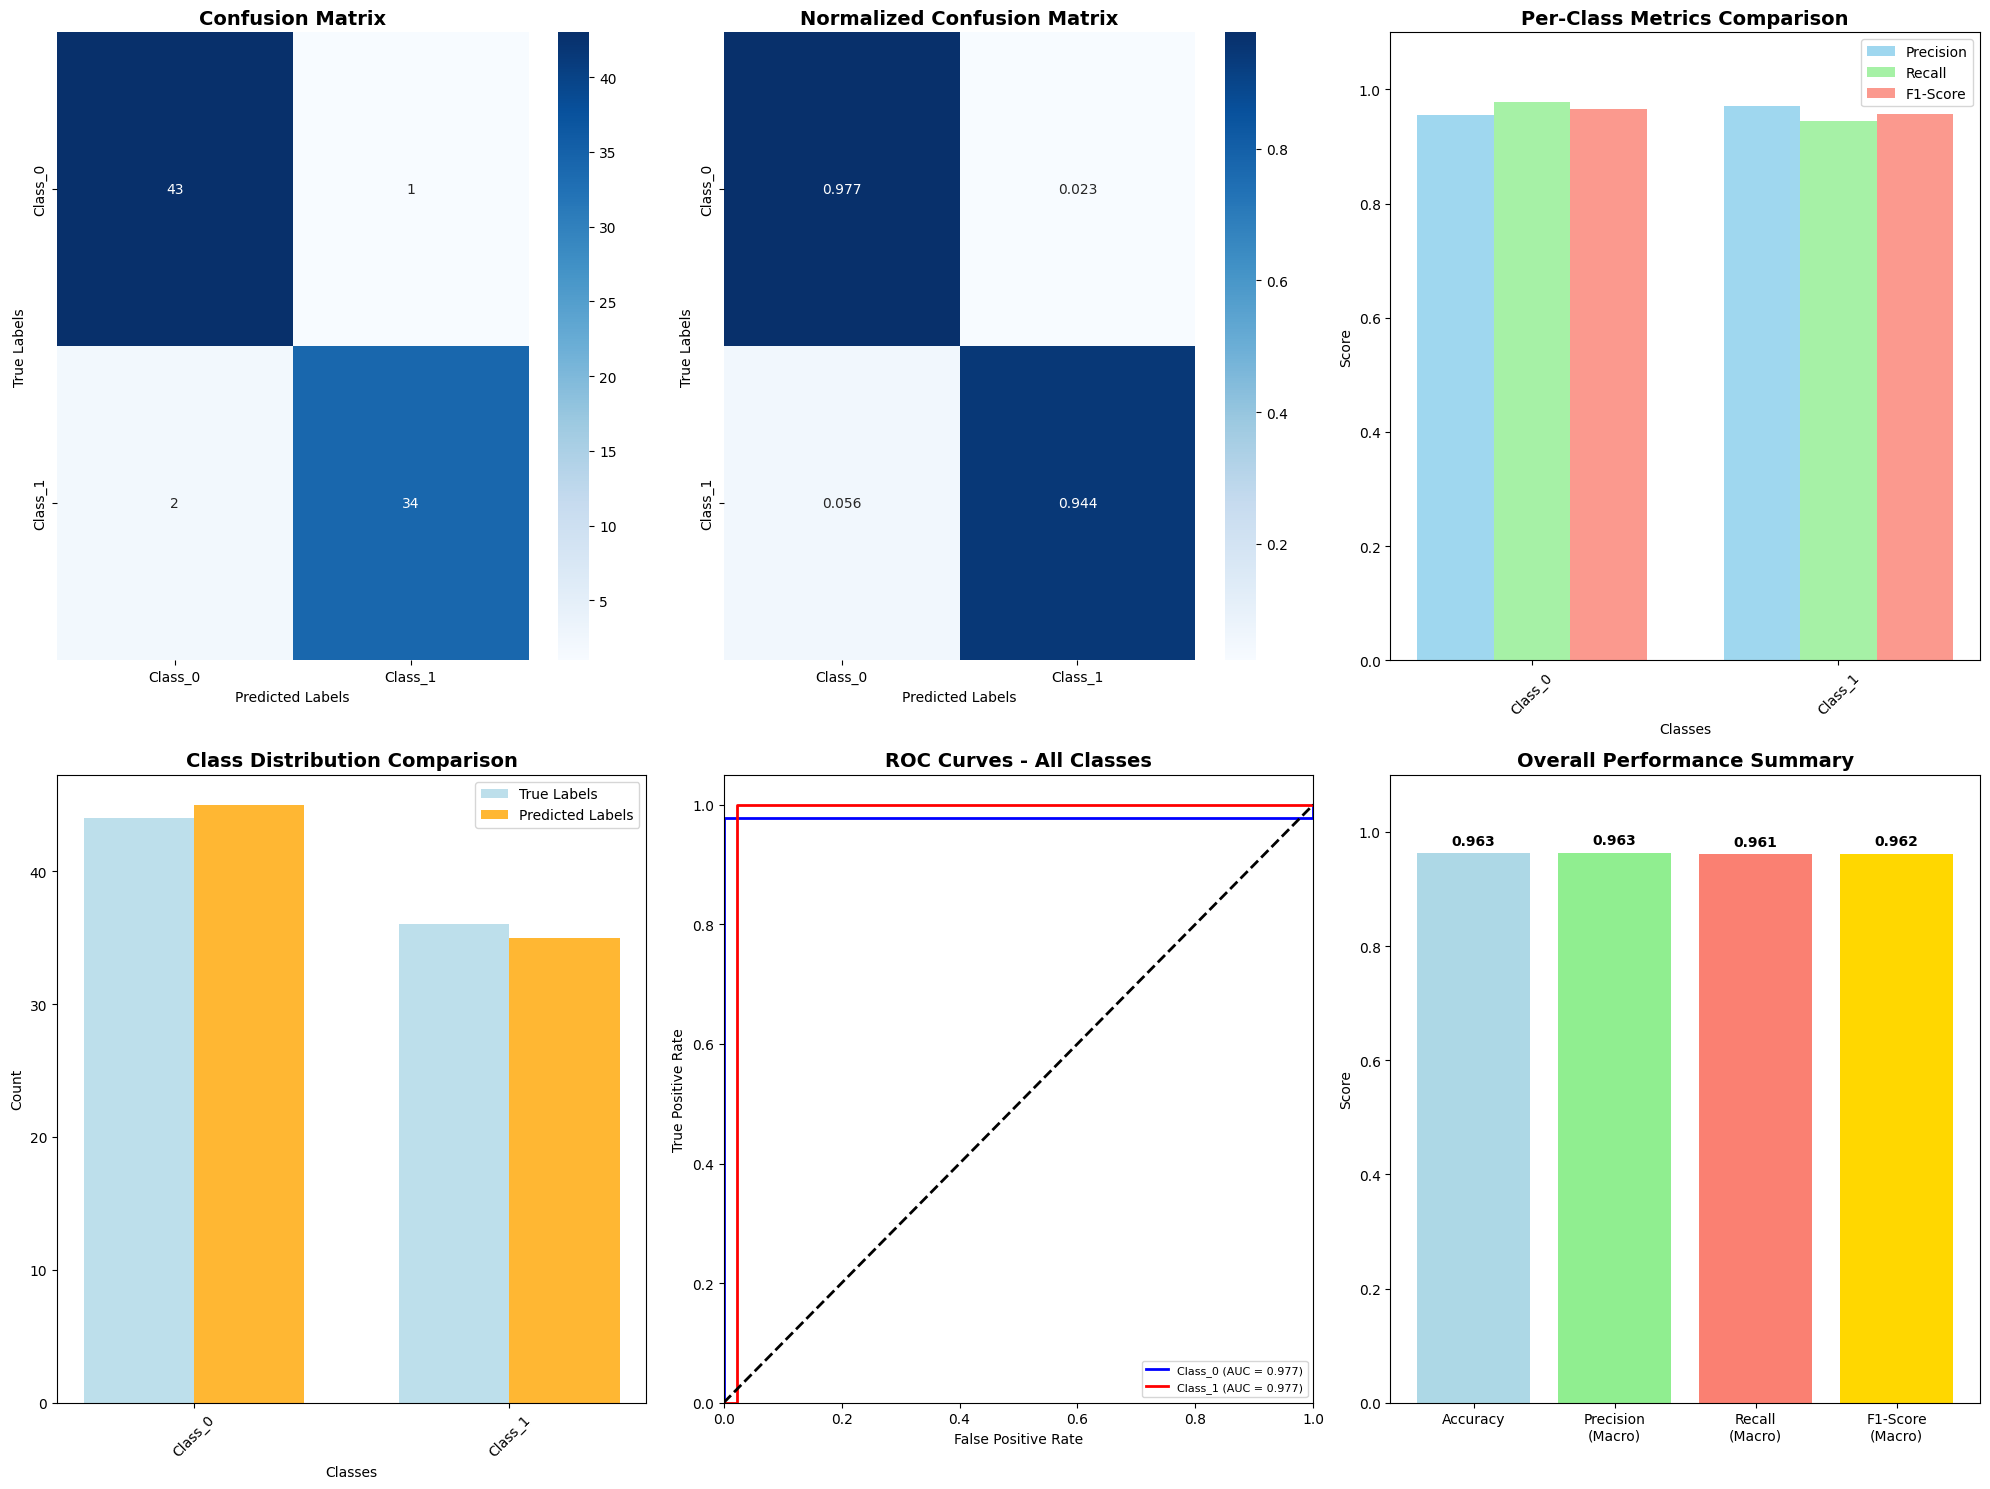


AUC-ROC Scores:
AUC (Macro): 0.9773
AUC (Micro): 0.9839
AUC (Weighted): 0.9773

           STACKING ENSEMBLE EVALUATION COMPLETE
Final Ensemble Accuracy: 0.9625
Final Ensemble F1-Score (Macro): 0.9620
Final Ensemble Precision (Macro): 0.9635
Final Ensemble Recall (Macro): 0.9609
Final Ensemble AUC (Macro): 0.9773

Total Classes Detected: 2
Class Names: ['Class_0', 'Class_1']


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                          f1_score, confusion_matrix, classification_report,
                          roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

def evaluate_stacking_ensemble(meta_model, val_loader, device, class_names=None):
   """
   Comprehensive evaluation of stacking ensemble performance with automatic class detection
   """
   
   # Get predictions from meta model
   meta_model.eval()
   all_predictions = []
   all_probabilities = []
   all_true_labels = []
   
   print("Generating predictions from meta model...")
   with torch.no_grad():
       for batch_x, batch_y in val_loader:
           batch_x = batch_x.to(device)
           outputs = meta_model(batch_x)
           
           # Get probabilities using softmax
           probabilities = torch.softmax(outputs, dim=1)
           _, predicted = torch.max(outputs, 1)
           
           all_predictions.extend(predicted.cpu().numpy())
           all_probabilities.extend(probabilities.cpu().numpy())
           all_true_labels.extend(batch_y.numpy())
   
   # Convert to numpy arrays
   predictions = np.array(all_predictions)
   probabilities = np.array(all_probabilities)
   true_labels = np.array(all_true_labels)
   
   # AUTOMATIC CLASS DETECTION
   unique_classes = np.unique(np.concatenate([true_labels, predictions]))
   num_classes = len(unique_classes)
   
   print(f"\nDetected {num_classes} unique classes: {unique_classes}")
   
   # Class distribution analysis
   print("\nClass distribution in true labels:")
   unique_true, counts_true = np.unique(true_labels, return_counts=True)
   for cls, count in zip(unique_true, counts_true):
       print(f"  Class {cls}: {count} samples")
       
   print("\nClass distribution in predictions:")
   unique_pred, counts_pred = np.unique(predictions, return_counts=True)
   for cls, count in zip(unique_pred, counts_pred):
       print(f"  Class {cls}: {count} samples")
   
   # Auto-generate class names if not provided or mismatch
   if class_names is None or len(class_names) != num_classes:
       class_names = [f'Class_{i}' for i in unique_classes]
       print(f"\nUsing auto-generated class names: {class_names}")
   
   print("\n" + "="*80)
   print("           STACKING ENSEMBLE PERFORMANCE EVALUATION")
   print("="*80)
   
   # Basic Metrics
   accuracy = accuracy_score(true_labels, predictions)
   
   # Use zero_division parameter to handle edge cases
   precision_macro = precision_score(true_labels, predictions, average='macro', zero_division=0)
   precision_micro = precision_score(true_labels, predictions, average='micro', zero_division=0)
   precision_weighted = precision_score(true_labels, predictions, average='weighted', zero_division=0)
   
   recall_macro = recall_score(true_labels, predictions, average='macro', zero_division=0)
   recall_micro = recall_score(true_labels, predictions, average='micro', zero_division=0)
   recall_weighted = recall_score(true_labels, predictions, average='weighted', zero_division=0)
   
   f1_macro = f1_score(true_labels, predictions, average='macro', zero_division=0)
   f1_micro = f1_score(true_labels, predictions, average='micro', zero_division=0)
   f1_weighted = f1_score(true_labels, predictions, average='weighted', zero_division=0)
   
   print(f"Accuracy: {accuracy:.4f}")
   print(f"\nPrecision (Macro): {precision_macro:.4f}")
   print(f"Precision (Micro): {precision_micro:.4f}")
   print(f"Precision (Weighted): {precision_weighted:.4f}")
   
   print(f"\nRecall (Macro): {recall_macro:.4f}")
   print(f"Recall (Micro): {recall_micro:.4f}")
   print(f"Recall (Weighted): {recall_weighted:.4f}")
   
   print(f"\nF1-Score (Macro): {f1_macro:.4f}")
   print(f"F1-Score (Micro): {f1_micro:.4f}")
   print(f"F1-Score (Weighted): {f1_weighted:.4f}")
   
   # Per-class metrics with proper labels
   print("\n" + "="*80)
   print("           PER-CLASS DETAILED REPORT")
   print("="*80)
   try:
       print(classification_report(true_labels, predictions, 
                                 labels=unique_classes,
                                 target_names=class_names,
                                 zero_division=0))
   except Exception as e:
       print(f"Classification report error: {e}")
       print("Simplified per-class metrics:")
       for i, cls in enumerate(unique_classes):
           cls_precision = precision_score(true_labels, predictions, labels=[cls], average=None, zero_division=0)
           cls_recall = recall_score(true_labels, predictions, labels=[cls], average=None, zero_division=0)
           cls_f1 = f1_score(true_labels, predictions, labels=[cls], average=None, zero_division=0)
           if len(cls_precision) > 0:
               print(f"{class_names[i]}: Precision={cls_precision[0]:.3f}, Recall={cls_recall[0]:.3f}, F1={cls_f1[0]:.3f}")
   
   # Confusion Matrix
   cm = confusion_matrix(true_labels, predictions, labels=unique_classes)
   
   # Create visualization
   fig_height = max(15, num_classes * 3)
   fig_width = max(20, num_classes * 4)
   plt.figure(figsize=(fig_width, fig_height))
   
   # Determine subplot layout based on number of classes
   if num_classes <= 2:
       subplot_rows, subplot_cols = 2, 3
   else:
       subplot_rows, subplot_cols = 3, 4
   
   # Plot 1: Confusion Matrix
   plt.subplot(subplot_rows, subplot_cols, 1)
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=class_names, yticklabels=class_names)
   plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
   plt.xlabel('Predicted Labels')
   plt.ylabel('True Labels')
   
   # Plot 2: Normalized Confusion Matrix
   plt.subplot(subplot_rows, subplot_cols, 2)
   cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)  # Add small epsilon to avoid division by zero
   sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
   plt.title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
   plt.xlabel('Predicted Labels')
   plt.ylabel('True Labels')
   
   # Plot 3: Per-class Metrics
   plt.subplot(subplot_rows, subplot_cols, 3)
   try:
       precision_per_class = precision_score(true_labels, predictions, labels=unique_classes, average=None, zero_division=0)
       recall_per_class = recall_score(true_labels, predictions, labels=unique_classes, average=None, zero_division=0)
       f1_per_class = f1_score(true_labels, predictions, labels=unique_classes, average=None, zero_division=0)
       
       x_pos = np.arange(len(class_names))
       width = 0.25
       
       plt.bar(x_pos - width, precision_per_class, width, label='Precision', alpha=0.8, color='skyblue')
       plt.bar(x_pos, recall_per_class, width, label='Recall', alpha=0.8, color='lightgreen')
       plt.bar(x_pos + width, f1_per_class, width, label='F1-Score', alpha=0.8, color='salmon')
       
       plt.xlabel('Classes')
       plt.ylabel('Score')
       plt.title('Per-Class Metrics Comparison', fontsize=14, fontweight='bold')
       plt.xticks(x_pos, class_names, rotation=45)
       plt.legend()
       plt.ylim(0, 1.1)
   except Exception as e:
       plt.text(0.5, 0.5, f'Error in per-class metrics: {str(e)[:50]}...', 
               ha='center', va='center', transform=plt.gca().transAxes)
       plt.title('Per-Class Metrics (Error)', fontsize=14)
   
   # Plot 4: Class Distribution
   plt.subplot(subplot_rows, subplot_cols, 4)
   true_counts = np.zeros(num_classes)
   pred_counts = np.zeros(num_classes)
   
   for i, cls in enumerate(unique_classes):
       true_counts[i] = np.sum(true_labels == cls)
       pred_counts[i] = np.sum(predictions == cls)
   
   x_pos = np.arange(len(class_names))
   width = 0.35
   
   plt.bar(x_pos - width/2, true_counts, width, label='True Labels', alpha=0.8, color='lightblue')
   plt.bar(x_pos + width/2, pred_counts, width, label='Predicted Labels', alpha=0.8, color='orange')
   
   plt.xlabel('Classes')
   plt.ylabel('Count')
   plt.title('Class Distribution Comparison', fontsize=14, fontweight='bold')
   plt.xticks(x_pos, class_names, rotation=45)
   plt.legend()
   
   # ROC Curves (only for binary classification or multiclass with proper probabilities)
   if num_classes >= 2 and probabilities.shape[1] >= num_classes:
       try:
           # Binarize labels for ROC calculation
           y_bin = label_binarize(true_labels, classes=unique_classes)
           if num_classes == 2:
               y_bin = np.column_stack([1 - y_bin, y_bin])
           
           # Plot 5: ROC Curves
           plt.subplot(subplot_rows, subplot_cols, 5)
           colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
           
           roc_auc_scores = []
           for i in range(num_classes):
               if i < len(colors):
                   color = colors[i]
               else:
                   color = plt.cm.Set1(i % 10)
               
               # Ensure we have the right probability column
               if i < probabilities.shape[1]:
                   fpr, tpr, _ = roc_curve(y_bin[:, i], probabilities[:, i])
                   roc_auc = auc(fpr, tpr)
                   roc_auc_scores.append(roc_auc)
                   
                   plt.plot(fpr, tpr, color=color, lw=2,
                           label=f'{class_names[i]} (AUC = {roc_auc:.3f})')
           
           plt.plot([0, 1], [0, 1], 'k--', lw=2)
           plt.xlim([0.0, 1.0])
           plt.ylim([0.0, 1.05])
           plt.xlabel('False Positive Rate')
           plt.ylabel('True Positive Rate')
           plt.title('ROC Curves - All Classes', fontsize=14, fontweight='bold')
           plt.legend(loc="lower right", fontsize=8)
           
       except Exception as e:
           plt.subplot(subplot_rows, subplot_cols, 5)
           plt.text(0.5, 0.5, f'ROC Curve Error: {str(e)[:50]}...', 
                   ha='center', va='center', transform=plt.gca().transAxes)
           plt.title('ROC Curves (Error)', fontsize=14)
   
   # Plot 6: Performance Summary
   plt.subplot(subplot_rows, subplot_cols, 6)
   metrics_names = ['Accuracy', 'Precision\n(Macro)', 'Recall\n(Macro)', 'F1-Score\n(Macro)']
   metrics_values = [accuracy, precision_macro, recall_macro, f1_macro]
   
   bars = plt.bar(metrics_names, metrics_values, color=['lightblue', 'lightgreen', 'salmon', 'gold'])
   plt.title('Overall Performance Summary', fontsize=14, fontweight='bold')
   plt.ylabel('Score')
   plt.ylim(0, 1.1)
   
   # Add value labels on bars
   for bar, value in zip(bars, metrics_values):
       plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
               f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
   
   plt.tight_layout()
   plt.show()
   
   # Calculate AUC scores
   auc_macro = auc_micro = auc_weighted = None
   try:
       if num_classes >= 2 and probabilities.shape[1] >= num_classes:
           y_bin = label_binarize(true_labels, classes=unique_classes)
           if num_classes == 2:
               y_bin = np.column_stack([1 - y_bin, y_bin])
           
           auc_macro = roc_auc_score(y_bin, probabilities[:, :num_classes], average='macro')
           auc_micro = roc_auc_score(y_bin, probabilities[:, :num_classes], average='micro')
           auc_weighted = roc_auc_score(y_bin, probabilities[:, :num_classes], average='weighted')
           
           print(f"\nAUC-ROC Scores:")
           print(f"AUC (Macro): {auc_macro:.4f}")
           print(f"AUC (Micro): {auc_micro:.4f}")
           print(f"AUC (Weighted): {auc_weighted:.4f}")
   except Exception as e:
       print(f"\nAUC-ROC calculation failed: {e}")
   
   # Return comprehensive metrics
   metrics = {
       'accuracy': accuracy,
       'precision_macro': precision_macro,
       'precision_micro': precision_micro,
       'precision_weighted': precision_weighted,
       'recall_macro': recall_macro,
       'recall_micro': recall_micro,
       'recall_weighted': recall_weighted,
       'f1_macro': f1_macro,
       'f1_micro': f1_micro,
       'f1_weighted': f1_weighted,
       'confusion_matrix': cm,
       'auc_macro': auc_macro,
       'auc_micro': auc_micro,
       'auc_weighted': auc_weighted,
       'num_classes': num_classes,
       'unique_classes': unique_classes,
       'class_names': class_names,
       'predictions': predictions,
       'probabilities': probabilities,
       'true_labels': true_labels
   }
   
   return metrics

# Usage - Evaluate your stacking ensemble
print("Starting Stacking Ensemble Evaluation...")

# Evaluate the stacking ensemble model
ensemble_metrics = evaluate_stacking_ensemble(
   meta_model=meta_model,
   val_loader=val_loader,
   device=device
)

print("\n" + "="*80)
print("           STACKING ENSEMBLE EVALUATION COMPLETE")
print("="*80)
print(f"Final Ensemble Accuracy: {ensemble_metrics['accuracy']:.4f}")
print(f"Final Ensemble F1-Score (Macro): {ensemble_metrics['f1_macro']:.4f}")
print(f"Final Ensemble Precision (Macro): {ensemble_metrics['precision_macro']:.4f}")
print(f"Final Ensemble Recall (Macro): {ensemble_metrics['recall_macro']:.4f}")

if ensemble_metrics['auc_macro'] is not None:
   print(f"Final Ensemble AUC (Macro): {ensemble_metrics['auc_macro']:.4f}")

print(f"\nTotal Classes Detected: {ensemble_metrics['num_classes']}")
print(f"Class Names: {ensemble_metrics['class_names']}")

Starting Individual Models Evaluation...
           INDIVIDUAL MODELS PERFORMANCE EVALUATION

Evaluating MobileNet...
MobileNet - Accuracy: 0.5000, F1: 0.3333

Evaluating MobileNet-V2...
MobileNet-V2 - Accuracy: 0.5500, F1: 0.4357

Evaluating ShuffleNet-V2...
ShuffleNet-V2 - Accuracy: 0.9725, F1: 0.9725

Evaluating SqueezeNet...
SqueezeNet - Accuracy: 0.9475, F1: 0.9475

Evaluating NASNet-A...
NASNet-A - Accuracy: 0.9775, F1: 0.9775


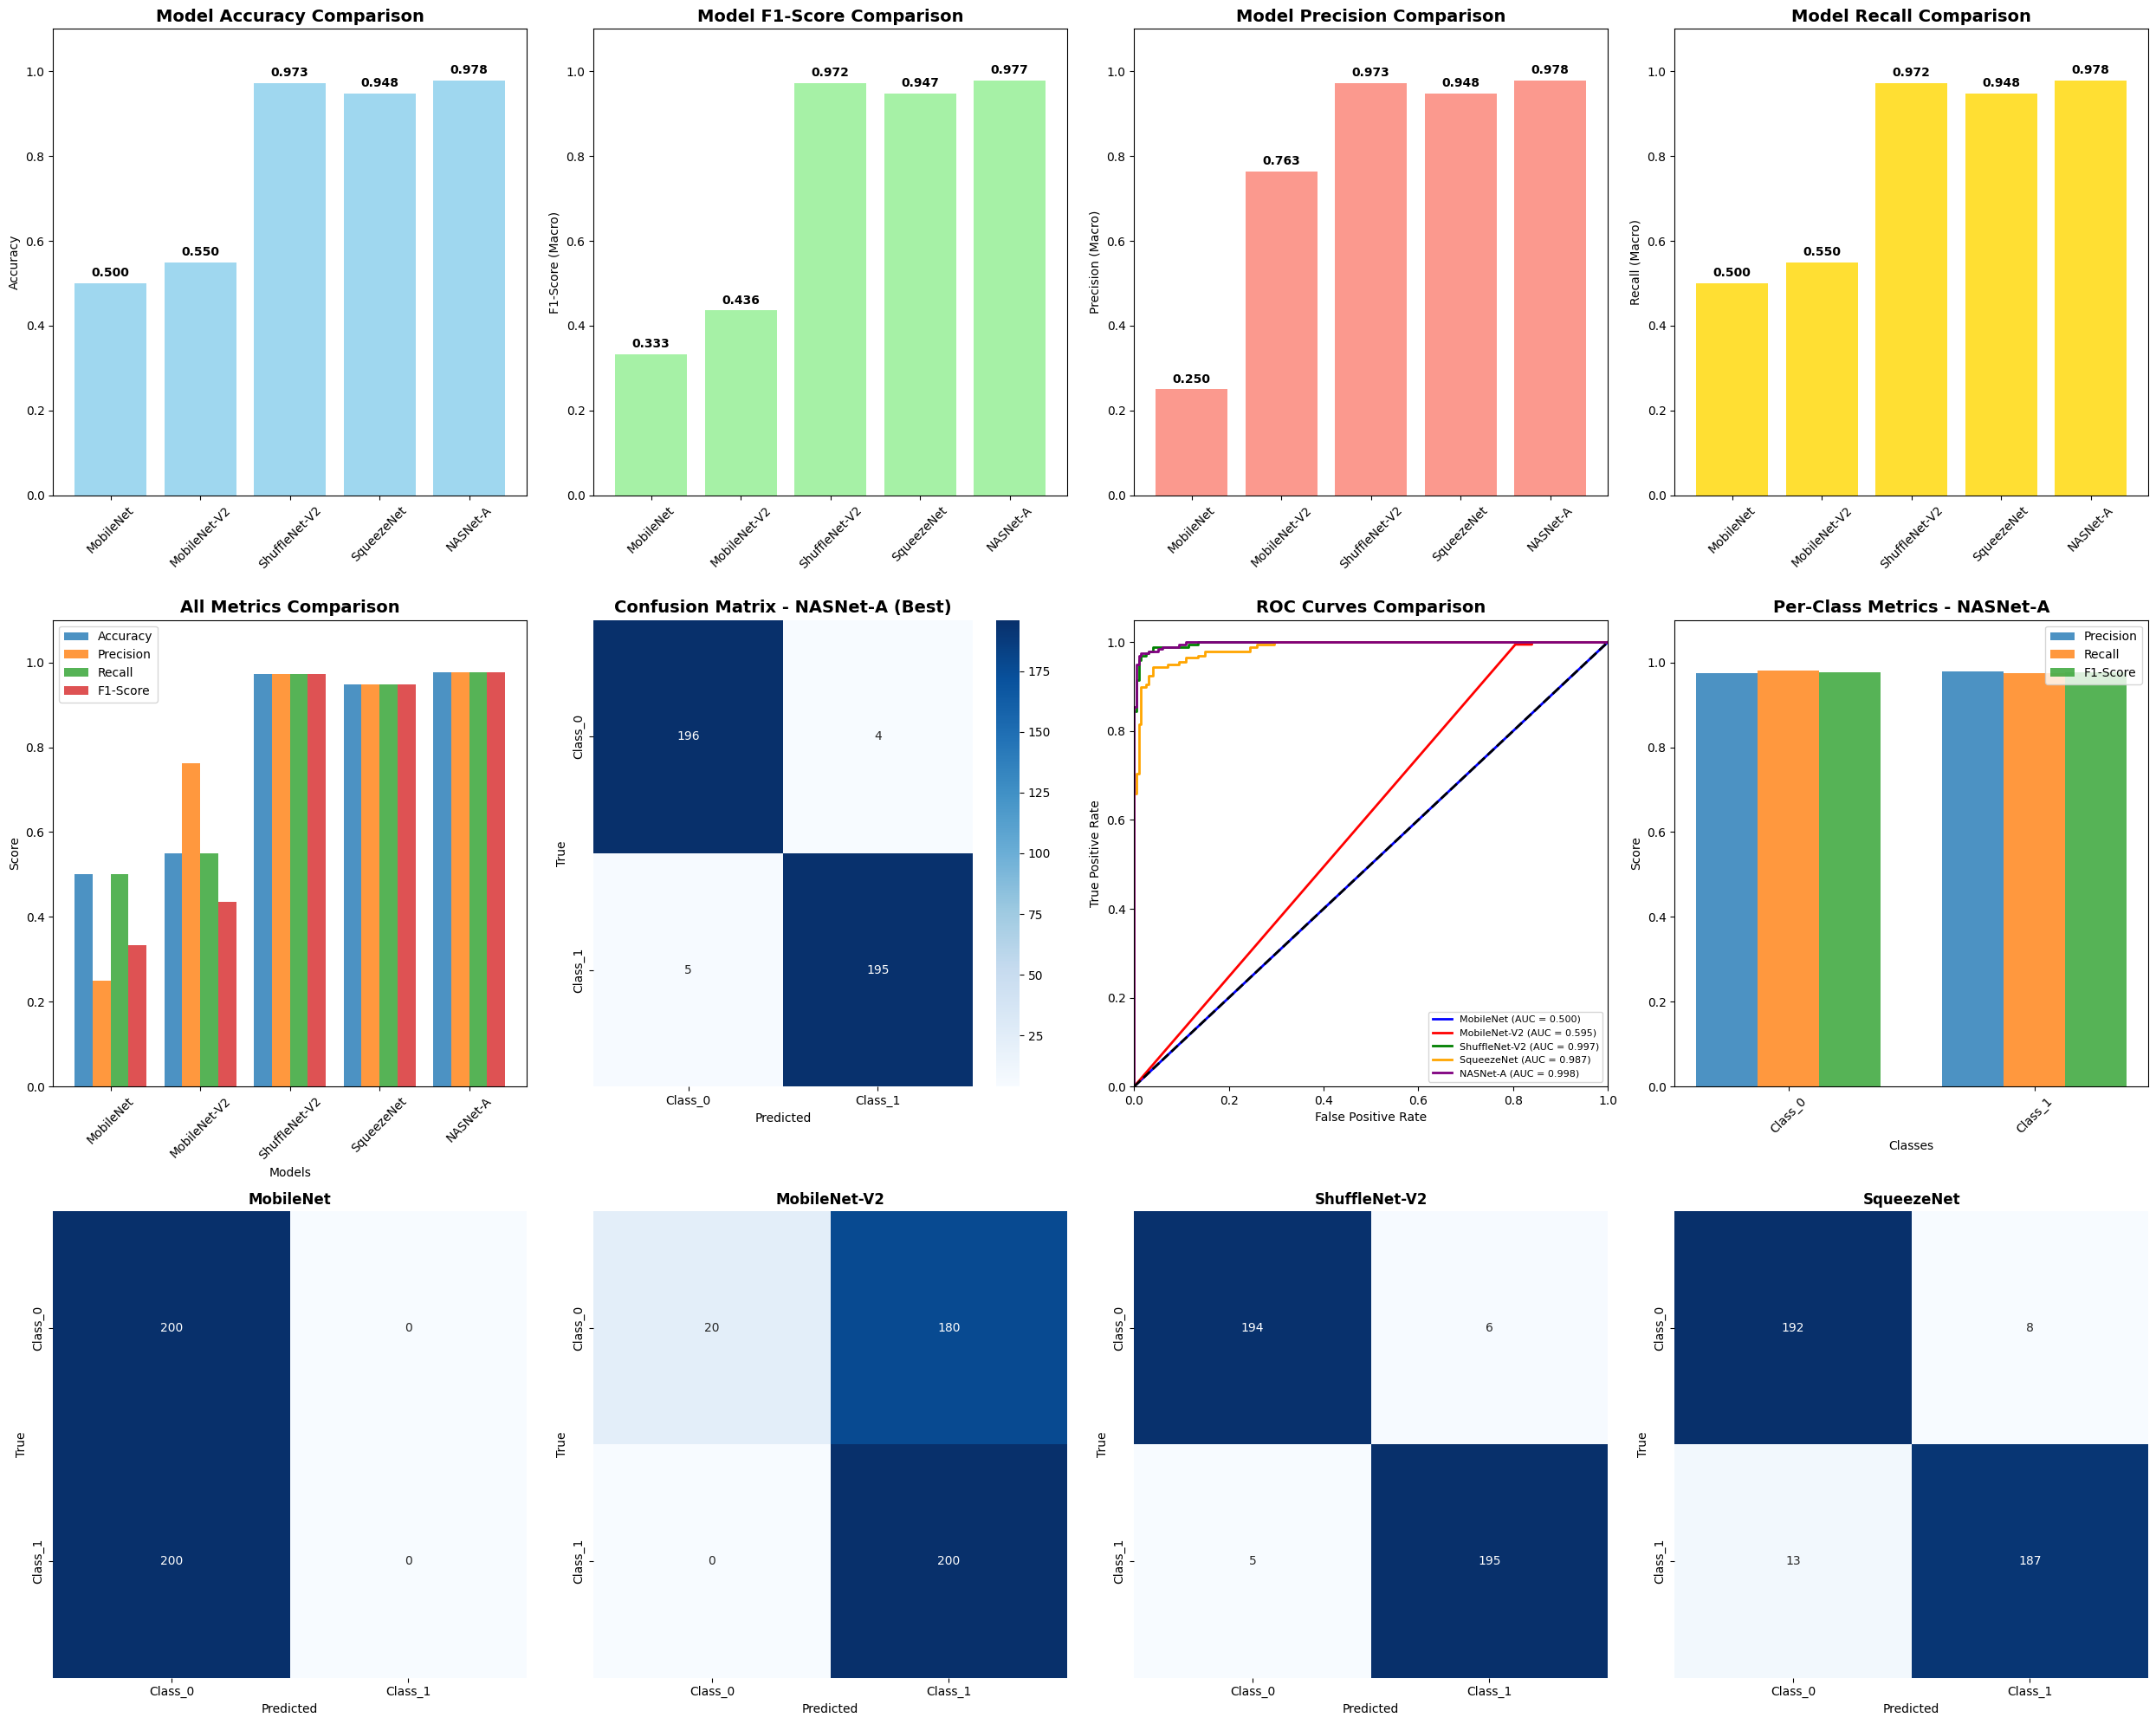


           DETAILED INDIVIDUAL MODEL RESULTS

1. NASNet-A:
   Accuracy:  0.9775
   Precision: 0.9775
   Recall:    0.9775
   F1-Score:  0.9775

2. ShuffleNet-V2:
   Accuracy:  0.9725
   Precision: 0.9725
   Recall:    0.9725
   F1-Score:  0.9725

3. SqueezeNet:
   Accuracy:  0.9475
   Precision: 0.9478
   Recall:    0.9475
   F1-Score:  0.9475

4. MobileNet-V2:
   Accuracy:  0.5500
   Precision: 0.7632
   Recall:    0.5500
   F1-Score:  0.4357

5. MobileNet:
   Accuracy:  0.5000
   Precision: 0.2500
   Recall:    0.5000
   F1-Score:  0.3333

🏆 Best Model: NASNet-A (Accuracy: 0.9775)
❌ Worst Model: MobileNet (Accuracy: 0.5000)
📈 Performance Gap: 0.4775 (47.8%)

Individual Models Evaluation Complete! ✅


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                          f1_score, confusion_matrix, classification_report,
                          roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

def evaluate_individual_models(models_dict, test_loader, device, class_names=None):
   """
   Evaluate individual base models performance
   
   Args:
       models_dict: Dictionary of models {'model_name': model_object}
       test_loader: Test data loader
       device: Device (cuda/cpu)
       class_names: List of class names
   """
   
   print("="*80)
   print("           INDIVIDUAL MODELS PERFORMANCE EVALUATION")
   print("="*80)
   
   # Store all model results
   all_results = {}
   all_predictions = {}
   all_probabilities = {}
   true_labels = None
   
   # Evaluate each model
   for model_name, model in models_dict.items():
       print(f"\nEvaluating {model_name}...")
       
       model.eval()
       predictions = []
       probabilities = []
       labels = []
       
       with torch.no_grad():
           for inputs, batch_labels in test_loader:
               inputs = inputs.to(device)
               outputs = model(inputs)
               
               # Get probabilities and predictions
               probs = torch.softmax(outputs, dim=1)
               _, preds = torch.max(outputs, 1)
               
               predictions.extend(preds.cpu().numpy())
               probabilities.extend(probs.cpu().numpy())
               labels.extend(batch_labels.numpy())
       
       # Convert to numpy arrays
       predictions = np.array(predictions)
       probabilities = np.array(probabilities)
       labels = np.array(labels)
       
       # Store true labels (same for all models)
       if true_labels is None:
           true_labels = labels
       
       # Store predictions
       all_predictions[model_name] = predictions
       all_probabilities[model_name] = probabilities
       
       # Calculate metrics
       accuracy = accuracy_score(labels, predictions)
       precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
       recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)
       f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
       
       all_results[model_name] = {
           'accuracy': accuracy,
           'precision_macro': precision_macro,
           'recall_macro': recall_macro,
           'f1_macro': f1_macro,
           'predictions': predictions,
           'probabilities': probabilities
       }
       
       print(f"{model_name} - Accuracy: {accuracy:.4f}, F1: {f1_macro:.4f}")
   
   # Auto-detect classes
   unique_classes = np.unique(true_labels)
   num_classes = len(unique_classes)
   
   if class_names is None or len(class_names) != num_classes:
       class_names = [f'Class_{i}' for i in unique_classes]
   
   # Create comprehensive comparison visualization
   fig = plt.figure(figsize=(25, 20))
   
   # 1. Overall Performance Comparison
   plt.subplot(3, 4, 1)
   model_names = list(models_dict.keys())
   accuracies = [all_results[name]['accuracy'] for name in model_names]
   
   bars = plt.bar(model_names, accuracies, color='skyblue', alpha=0.8)
   plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
   plt.ylabel('Accuracy')
   plt.xticks(rotation=45)
   plt.ylim(0, 1.1)
   
   # Add value labels
   for bar, acc in zip(bars, accuracies):
       plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
               f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
   
   # 2. F1-Score Comparison
   plt.subplot(3, 4, 2)
   f1_scores = [all_results[name]['f1_macro'] for name in model_names]
   
   bars = plt.bar(model_names, f1_scores, color='lightgreen', alpha=0.8)
   plt.title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
   plt.ylabel('F1-Score (Macro)')
   plt.xticks(rotation=45)
   plt.ylim(0, 1.1)
   
   for bar, f1 in zip(bars, f1_scores):
       plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
               f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')
   
   # 3. Precision Comparison
   plt.subplot(3, 4, 3)
   precisions = [all_results[name]['precision_macro'] for name in model_names]
   
   bars = plt.bar(model_names, precisions, color='salmon', alpha=0.8)
   plt.title('Model Precision Comparison', fontsize=14, fontweight='bold')
   plt.ylabel('Precision (Macro)')
   plt.xticks(rotation=45)
   plt.ylim(0, 1.1)
   
   for bar, prec in zip(bars, precisions):
       plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
               f'{prec:.3f}', ha='center', va='bottom', fontweight='bold')
   
   # 4. Recall Comparison
   plt.subplot(3, 4, 4)
   recalls = [all_results[name]['recall_macro'] for name in model_names]
   
   bars = plt.bar(model_names, recalls, color='gold', alpha=0.8)
   plt.title('Model Recall Comparison', fontsize=14, fontweight='bold')
   plt.ylabel('Recall (Macro)')
   plt.xticks(rotation=45)
   plt.ylim(0, 1.1)
   
   for bar, rec in zip(bars, recalls):
       plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
               f'{rec:.3f}', ha='center', va='bottom', fontweight='bold')
   
   # 5. All Metrics Together
   plt.subplot(3, 4, 5)
   x = np.arange(len(model_names))
   width = 0.2
   
   plt.bar(x - width*1.5, accuracies, width, label='Accuracy', alpha=0.8)
   plt.bar(x - width*0.5, precisions, width, label='Precision', alpha=0.8)
   plt.bar(x + width*0.5, recalls, width, label='Recall', alpha=0.8)
   plt.bar(x + width*1.5, f1_scores, width, label='F1-Score', alpha=0.8)
   
   plt.title('All Metrics Comparison', fontsize=14, fontweight='bold')
   plt.ylabel('Score')
   plt.xlabel('Models')
   plt.xticks(x, model_names, rotation=45)
   plt.legend()
   plt.ylim(0, 1.1)
   
   # 6. Confusion Matrix for Best Model
   plt.subplot(3, 4, 6)
   best_model = max(model_names, key=lambda x: all_results[x]['accuracy'])
   best_predictions = all_results[best_model]['predictions']
   
   cm = confusion_matrix(true_labels, best_predictions, labels=unique_classes)
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
   plt.title(f'Confusion Matrix - {best_model} (Best)', fontsize=14, fontweight='bold')
   plt.xlabel('Predicted')
   plt.ylabel('True')
   
   # 7. ROC Curves (if applicable)
   if num_classes >= 2:
       plt.subplot(3, 4, 7)
       colors = ['blue', 'red', 'green', 'orange', 'purple']
       
       try:
           for i, (model_name, color) in enumerate(zip(model_names, colors)):
               probs = all_results[model_name]['probabilities']
               
               if num_classes == 2:
                   # Binary classification
                   fpr, tpr, _ = roc_curve(true_labels, probs[:, 1])
                   roc_auc = auc(fpr, tpr)
                   plt.plot(fpr, tpr, color=color, lw=2,
                           label=f'{model_name} (AUC = {roc_auc:.3f})')
               else:
                   # Multiclass - use macro average
                   y_bin = label_binarize(true_labels, classes=unique_classes)
                   fpr_macro, tpr_macro, roc_auc_macro = compute_macro_roc(y_bin, probs, num_classes)
                   plt.plot(fpr_macro, tpr_macro, color=color, lw=2,
                           label=f'{model_name} (AUC = {roc_auc_macro:.3f})')
           
           plt.plot([0, 1], [0, 1], 'k--', lw=2)
           plt.xlim([0.0, 1.0])
           plt.ylim([0.0, 1.05])
           plt.xlabel('False Positive Rate')
           plt.ylabel('True Positive Rate')
           plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
           plt.legend(loc="lower right", fontsize=8)
           
       except Exception as e:
           plt.text(0.5, 0.5, f'ROC Error: {str(e)[:30]}...', 
                   ha='center', va='center', transform=plt.gca().transAxes)
   
   # 8. Per-Class Performance (Best Model)
   plt.subplot(3, 4, 8)
   try:
       best_preds = all_results[best_model]['predictions']
       precision_per_class = precision_score(true_labels, best_preds, labels=unique_classes, average=None, zero_division=0)
       recall_per_class = recall_score(true_labels, best_preds, labels=unique_classes, average=None, zero_division=0)
       f1_per_class = f1_score(true_labels, best_preds, labels=unique_classes, average=None, zero_division=0)
       
       x_pos = np.arange(len(class_names))
       width = 0.25
       
       plt.bar(x_pos - width, precision_per_class, width, label='Precision', alpha=0.8)
       plt.bar(x_pos, recall_per_class, width, label='Recall', alpha=0.8)
       plt.bar(x_pos + width, f1_per_class, width, label='F1-Score', alpha=0.8)
       
       plt.xlabel('Classes')
       plt.ylabel('Score')
       plt.title(f'Per-Class Metrics - {best_model}', fontsize=14, fontweight='bold')
       plt.xticks(x_pos, class_names, rotation=45)
       plt.legend()
       plt.ylim(0, 1.1)
       
   except Exception as e:
       plt.text(0.5, 0.5, f'Per-class Error: {str(e)[:30]}...', 
               ha='center', va='center', transform=plt.gca().transAxes)
   
   # 9-12. Individual Model Confusion Matrices
   for i, model_name in enumerate(model_names[:4]):  # Show first 4 models
       plt.subplot(3, 4, 9 + i)
       preds = all_results[model_name]['predictions']
       cm = confusion_matrix(true_labels, preds, labels=unique_classes)
       sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                   xticklabels=class_names, yticklabels=class_names)
       plt.title(f'{model_name}', fontsize=12, fontweight='bold')
       plt.xlabel('Predicted')
       plt.ylabel('True')
   
   plt.tight_layout()
   plt.show()
   
   # Print detailed results
   print("\n" + "="*80)
   print("           DETAILED INDIVIDUAL MODEL RESULTS")
   print("="*80)
   
   # Sort models by accuracy
   sorted_models = sorted(model_names, key=lambda x: all_results[x]['accuracy'], reverse=True)
   
   for i, model_name in enumerate(sorted_models):
       results = all_results[model_name]
       print(f"\n{i+1}. {model_name}:")
       print(f"   Accuracy:  {results['accuracy']:.4f}")
       print(f"   Precision: {results['precision_macro']:.4f}")
       print(f"   Recall:    {results['recall_macro']:.4f}")
       print(f"   F1-Score:  {results['f1_macro']:.4f}")
   
   # Best and Worst models
   best_model = sorted_models[0]
   worst_model = sorted_models[-1]
   
   print(f"\n🏆 Best Model: {best_model} (Accuracy: {all_results[best_model]['accuracy']:.4f})")
   print(f"❌ Worst Model: {worst_model} (Accuracy: {all_results[worst_model]['accuracy']:.4f})")
   
   improvement = all_results[best_model]['accuracy'] - all_results[worst_model]['accuracy']
   print(f"📈 Performance Gap: {improvement:.4f} ({improvement*100:.1f}%)")
   
   return all_results, true_labels

def compute_macro_roc(y_bin, probabilities, num_classes):
   """Compute macro-average ROC curve for multiclass"""
   all_fpr = np.unique(np.concatenate([roc_curve(y_bin[:, i], probabilities[:, i])[0] 
                                      for i in range(num_classes)]))
   mean_tpr = np.zeros_like(all_fpr)
   
   for i in range(num_classes):
       fpr, tpr, _ = roc_curve(y_bin[:, i], probabilities[:, i])
       mean_tpr += np.interp(all_fpr, fpr, tpr)
   
   mean_tpr /= num_classes
   macro_auc = auc(all_fpr, mean_tpr)
   
   return all_fpr, mean_tpr, macro_auc

# Usage Example
def evaluate_all_individual_models(model1, model2, model3, model4, model5, test_loader, device):
   """
   Wrapper function to evaluate all your individual models
   """
   
   # Create models dictionary
   models_dict = {
       'MobileNet': model1,
       'MobileNet-V2': model2,
       'ShuffleNet-V2': model3,
       'SqueezeNet': model4,
       'NASNet-A': model5
   }
   
   # Define class names (modify according to your classes)
   class_names = ['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4']
   
   # Evaluate all models
   individual_results, true_labels = evaluate_individual_models(
       models_dict=models_dict,
       test_loader=test_loader,
       device=device,
       class_names=class_names
   )
   
   return individual_results, true_labels

# Run the evaluation
print("Starting Individual Models Evaluation...")

# Make sure your models are defined: model1, model2, model3, model4, model5
individual_results, true_labels = evaluate_all_individual_models(
   model1=model,   
   model2=model2, 
   model3=model3, 
   model4=model4, 
   model5=model5,
   test_loader=test_loader,  
   device=device
)

print("\nIndividual Models Evaluation Complete! ✅")